In [1]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


In [2]:
#!pip install sktime
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

import pmdarima

from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.inspection import permutation_importance

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter

import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

%matplotlib inline
pd.options.mode.chained_assignment= None

# References:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Loading Data

In [3]:
df_train_features = pd.read_csv('data/dengue_features_train.csv')
df_test_features = pd.read_csv('data/dengue_features_test.csv')
df_train_labels = pd.read_csv('data/dengue_labels_train.csv')
submission = pd.read_csv('data/submission_format.csv')

### Seperating data for SJ and IQ

In [4]:
df_train_features['month'] = pd.to_datetime(df_train_features['week_start_date']).dt.month
df_test_features['month'] = pd.to_datetime(df_test_features['week_start_date']).dt.month

df_train_features_sj = df_train_features.loc[df_train_features['city']=='sj',:].reset_index()
df_train_labels_sj = df_train_labels.loc[df_train_labels['city']=='sj',:].reset_index()
df_test_features_sj = df_test_features.loc[df_test_features['city']=='sj',:].reset_index()
print('San Juan:')
print('Total number of examples: ',df_train_features_sj.shape[0])
print('Total number of dengues cases: ',df_train_labels_sj['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_sj['total_cases'].sum()/df_train_labels_sj.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_sj.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_sj.groupby('year')['total_cases'].sum().sort_index()]))

print('Iquitos:')
df_train_features_iq = df_train_features.loc[df_train_features['city']=='iq',:].reset_index()
df_train_labels_iq = df_train_labels.loc[df_train_labels['city']=='iq',:].reset_index()
df_test_features_iq = df_test_features.loc[df_test_features['city']=='iq',:].reset_index()
print('\nTotal number of examples: ', df_train_features_iq.shape[0])
print('Total number of dengues cases: ',df_train_labels_iq['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_iq['total_cases'].sum()/df_train_labels_iq.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_iq.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_iq.groupby('year')['total_cases'].sum().sort_index()]))

San Juan:
Total number of examples:  936
Total number of dengues cases:  31993
Total number of dengues cases per week on average:  35
Per year counts:



,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
no_of_weeks,35,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,17
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


Iquitos:

Total number of examples:  520
Total number of dengues cases:  3934
Total number of dengues cases per week on average:  8
Per year counts:



,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
no_of_weeks,26,52,52,52,52,52,52,52,52,52,26
total_cases,4,14,704,114,638,311,436,365,801,324,223


### Distribution of dengue cases

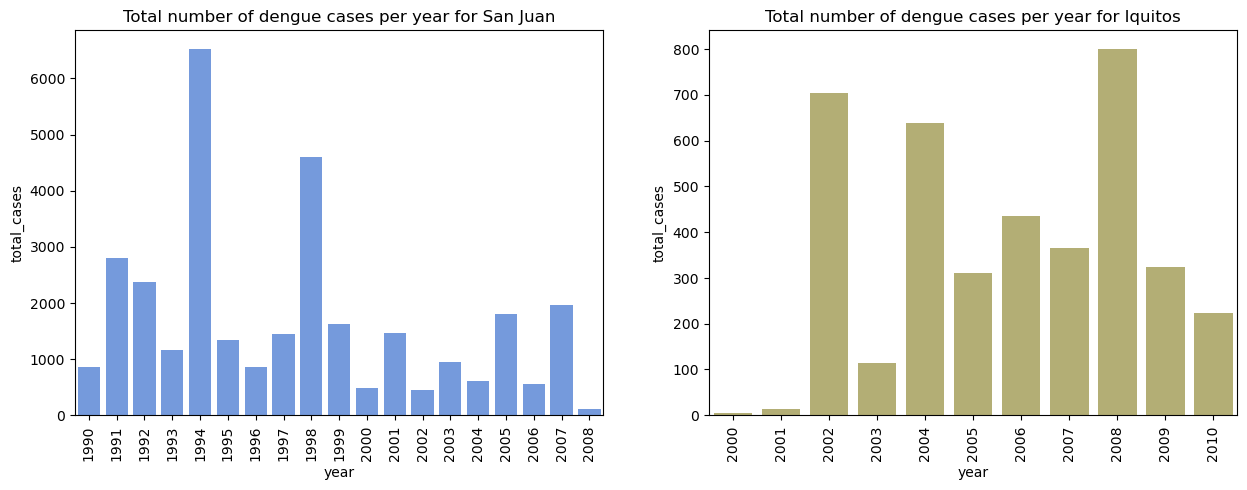

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
g1 = sns.barplot(data=df_train_labels_sj.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'cornflowerblue',ax=axs[0])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90);
g1.set_title('Total number of dengue cases per year for San Juan');
g2 = sns.barplot(data=df_train_labels_iq.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'darkkhaki',ax=axs[1])
axs[1].set_title('Total number of dengue cases per year for Iquitos')
g2.set_xticklabels(g2.get_xticklabels(),rotation=90);

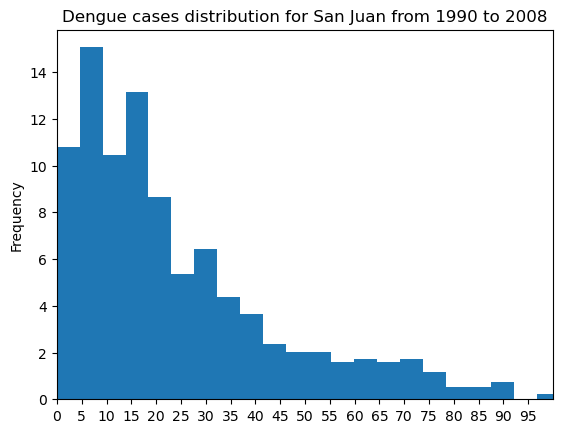

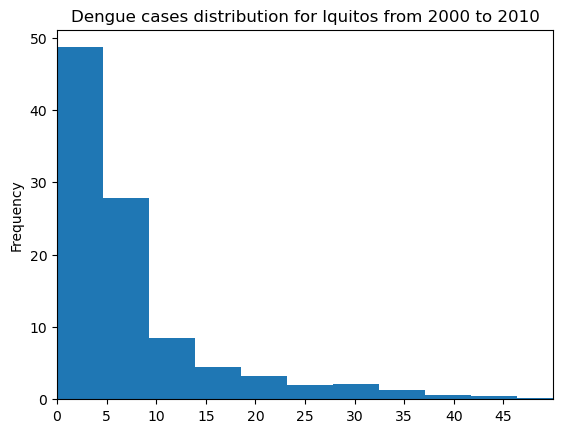

In [6]:
df = df_train_labels.loc[df_train_labels['city']=='sj','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=100)
plt.xlim((0,100))
plt.xticks(range(0,100,5));
plt.title('Dengue cases distribution for San Juan from 1990 to 2008');

plt.figure()
df = df_train_labels.loc[df_train_labels['city']=='iq','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=25)
plt.xlim((0,50))
plt.xticks(range(0,50,5));
plt.title('Dengue cases distribution for Iquitos from 2000 to 2010');

### Looking at monthly trends

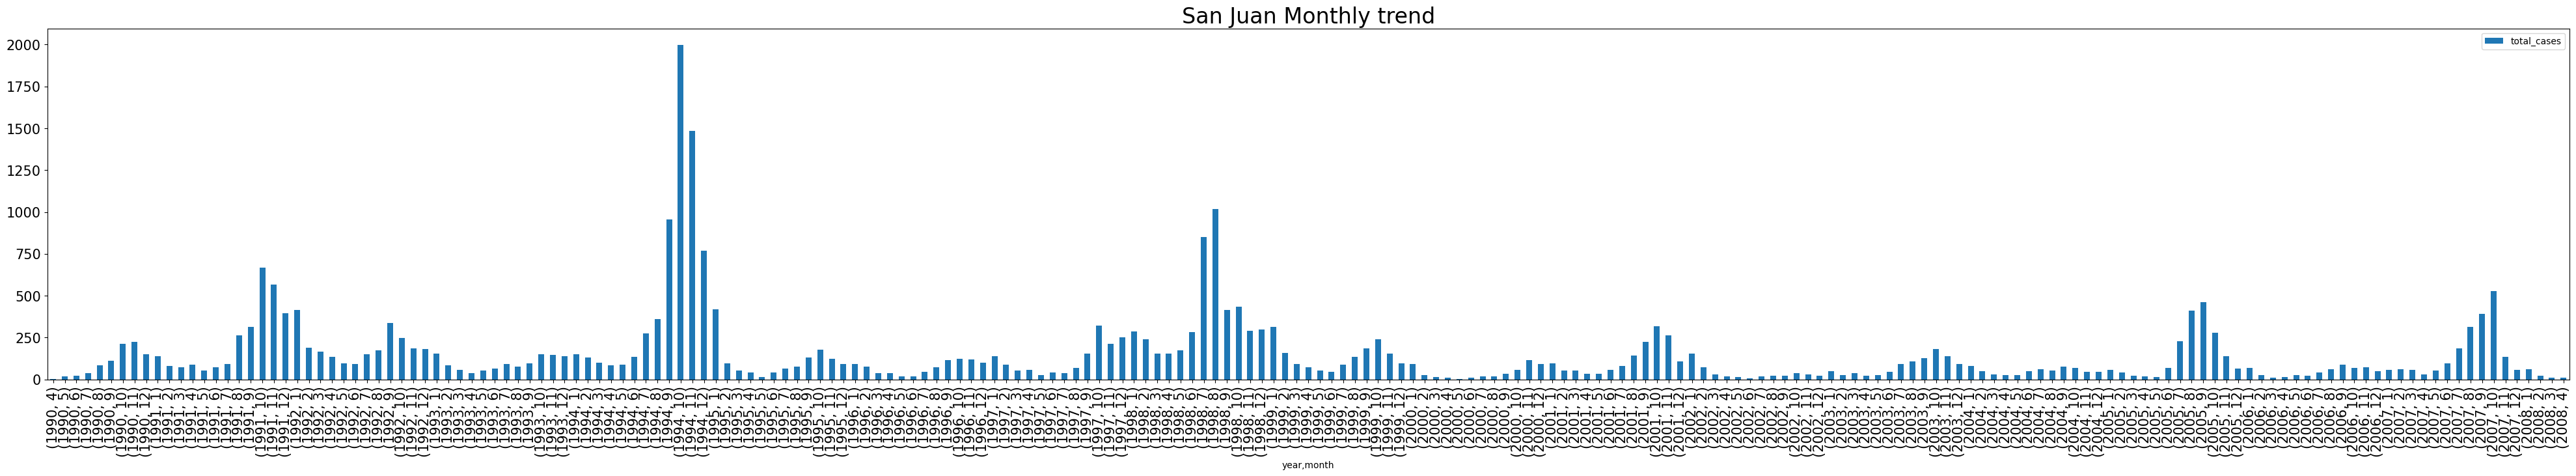

In [7]:
df_sj = pd.DataFrame(zip(df_train_features_sj['month'],df_train_features_sj['year'],df_train_labels_sj['total_cases']),columns=['month','year','total_cases'])
df_sj.set_index(['year', 'month'], inplace=True)
df_sj.groupby(['year','month']).sum().plot(kind='bar',figsize=(50,7),fontsize=15)
plt.title('San Juan Monthly trend',fontsize=24);

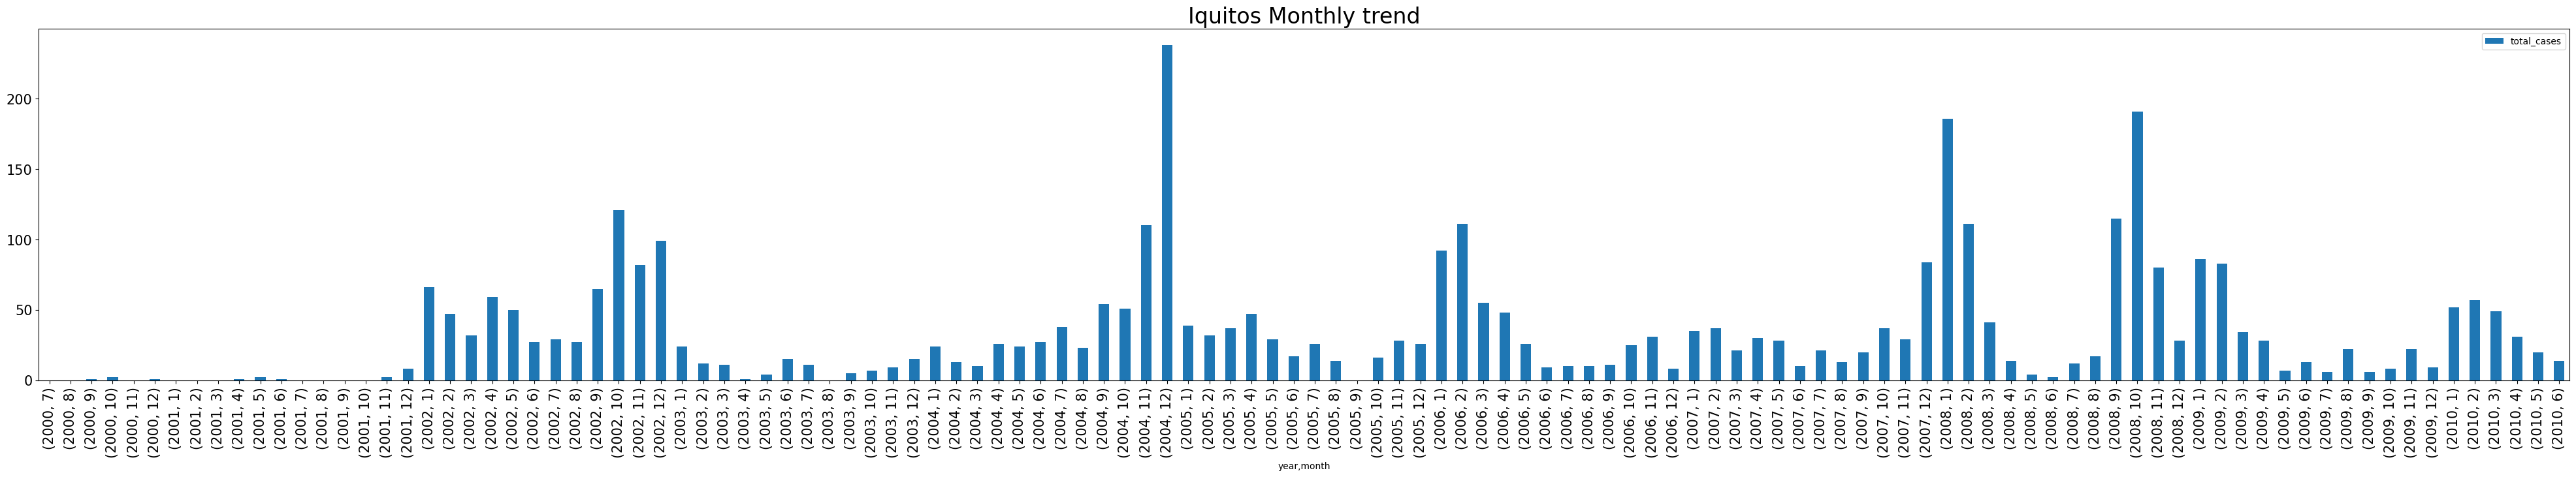

In [8]:
df_iq = pd.DataFrame(zip(df_train_features_iq['month'],df_train_features_iq['year'],df_train_labels_iq['total_cases']),columns=['month','year','total_cases'])
df_iq.set_index(['year', 'month'], inplace=True)
df_iq.groupby(['year','month']).sum().plot(kind='bar',figsize=(50,7),fontsize=15)
plt.title('Iquitos Monthly trend',fontsize=24);

### Feature understanding

In [9]:
df_train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,5
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,5
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,5


In [10]:
print('Number of total columns:',len(df_train_features.columns),'\n')
print(list(df_train_features.columns),'\n')
print('Number of useable features:', len(df_train_features.drop(['city', 'year', 'weekofyear', 'week_start_date'],axis=1).columns),'\n')
print('Info for iq = Iquitos and sj = San Juan:')
display(pd.DataFrame({
    'no. of observations (train)': df_train_features.groupby('city').size(),
    'from (train)': df_train_features.groupby('city')['year'].min(),
    'to (train)': df_train_features.groupby('city')['year'].max(),
    'no. of years (train)':df_train_features.groupby('city')['year'].nunique(),
    'no. of observations (test)': df_test_features.groupby('city').size(),
    'from (test)': df_test_features.groupby('city')['year'].min(),
    'to (test)': df_test_features.groupby('city')['year'].max(),
    'no. of years (test)':df_test_features.groupby('city')['year'].nunique(),
    'no. of dengues cases':df_train_labels.groupby('city')['total_cases'].sum(),
    'avg no. of dengues cases per week':df_train_labels.groupby('city')['total_cases'].mean()}))

Number of total columns: 25 

['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'month'] 

Number of useable features: 21 

Info for iq = Iquitos and sj = San Juan:


,no. of observations (train),from (train),to (train),no. of years (train),no. of observations (test),from (test),to (test),no. of years (test),no. of dengues cases,avg no. of dengues cases per week
city,,,,,,,,,,
iq,520,2000,2010,11,156,2010,2013,4,3934,7.565385
sj,936,1990,2008,19,260,2008,2013,6,31993,34.180556


In [11]:
useable_features = list(df_train_features.drop(['city','weekofyear','week_start_date','year'],axis=1).columns)

### Feature Description

In [12]:
ndvi = [x for x in list(df_train_features.columns) if 'ndvi' in x] 
reanalysis = [x for x in list(df_train_features.columns) if 'reanalysis' in x]
precip = [x for x in list(df_train_features.columns) if 'precipitation' in x]
station = [x for x in list(df_train_features.columns) if 'station' in x]
all_features = [ndvi,reanalysis,precip,station]
max_len = max([len(i) for i in all_features])
for i in range(len(all_features)):
    if len(all_features) < max_len:
        all_features[i] += [''] * (max_len - len(all_features[i]))

display(pd.DataFrame({
    'CDR Normalized Difference Vegetation Index':all_features[0],
    'NCEP Climate Forecast System Reanalysis':all_features[1],
    'CDR PERSIANN Precipitation Product':all_features[2],
    'GHCN daily climate data':all_features[3]}))

,CDR Normalized Difference Vegetation Index,NCEP Climate Forecast System Reanalysis,CDR PERSIANN Precipitation Product,GHCN daily climate data
0,ndvi_ne,reanalysis_air_temp_k,precipitation_amt_mm,station_avg_temp_c
1,ndvi_nw,reanalysis_avg_temp_k,,station_diur_temp_rng_c
2,ndvi_se,reanalysis_dew_point_temp_k,,station_max_temp_c
3,ndvi_sw,reanalysis_max_air_temp_k,,station_min_temp_c
4,,reanalysis_min_air_temp_k,,station_precip_mm
5,,reanalysis_precip_amt_kg_per_m2,,
6,,reanalysis_relative_humidity_percent,,
7,,reanalysis_sat_precip_amt_mm,,
8,,reanalysis_specific_humidity_g_per_kg,,
9,,reanalysis_tdtr_k,,


### Distribution of Features

#### Vegetation

In [13]:
def plot_distributions(ls,w,h,ft,r,c,feature,sharey=False):
    l = [x for x in ls if x != '']
    fig,axs = plt.subplots(nrows=r, ncols=c,figsize=(w,h),sharey=sharey)
    if hasattr(axs, "__len__"):
        axs = axs.flatten()
        for i,a in zip(l,axs):
            sns.boxplot(data=df_train_features, y=i, x="city",ax=a)
    else:
        for i in l:
            sns.boxplot(data=df_train_features, y=i, x="city",ax=axs)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Distribution of '+ feature +' features for both San Juan and Iquitos', fontsize = ft)

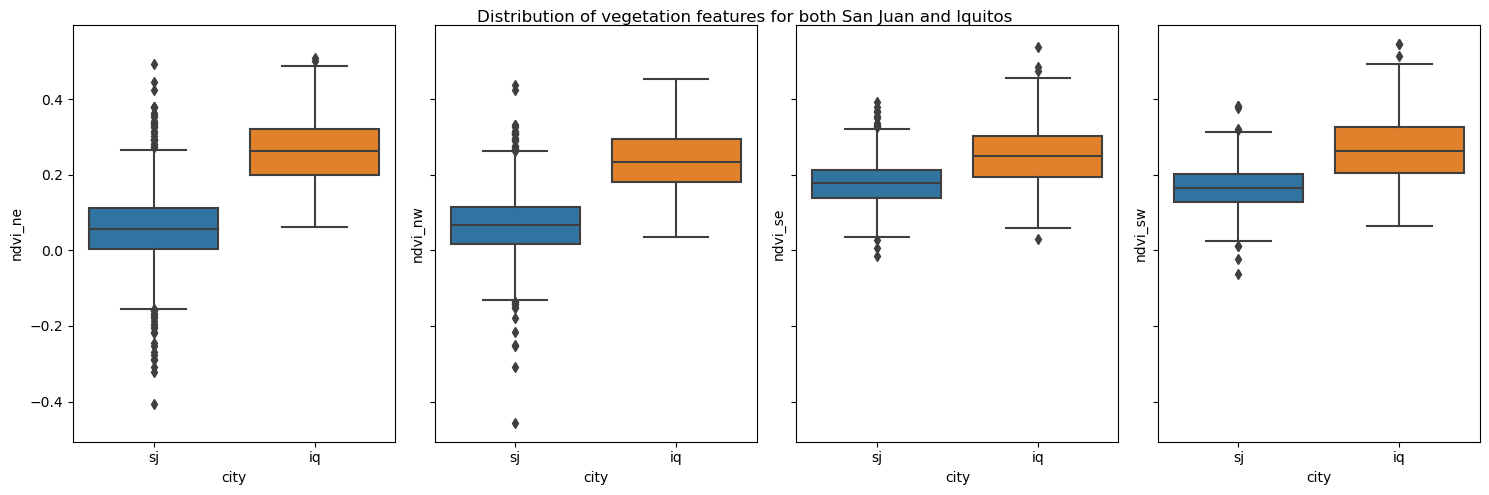

In [14]:
plot_distributions(ndvi,15,5,12,1,4,'vegetation',True)

There seems to be more vegetation in Iquitos compared to San Juan. Iquitos also seems to have fewer water bodies (cases where ndvi < 0). There are outlier areas in ndvi where there is more vegetation. 

In [15]:
sj_correlations = pd.concat([df_train_features_sj.loc[:,useable_features],df_train_labels_sj.loc[:,'total_cases']],axis=1).corr()
iq_correlations = pd.concat([df_train_features_iq.loc[:,useable_features],df_train_labels_iq.loc[:,'total_cases']],axis=1).corr()

In [16]:
def corr_heatmap(var,var_list,w=25,h=10):
    fig, axs = plt.subplots(1,2, figsize=(w,h))
    for i,j,k in zip(range(2),[sj_correlations,iq_correlations],['San Juan','Iquitos']):
        sns.heatmap(j.reset_index().loc[(j.reset_index()['index'].str.contains(var)|j.reset_index()['index'].str.contains("total_cases")),
                                                  [x for x in var_list if x != '']+['index']+['total_cases']].set_index('index'),
               cmap="crest",annot=True,ax=axs[i]);
    
        axs[i].title.set_text(k);
    fig.tight_layout()
    sns.set(style="whitegrid", font_scale=2.5)


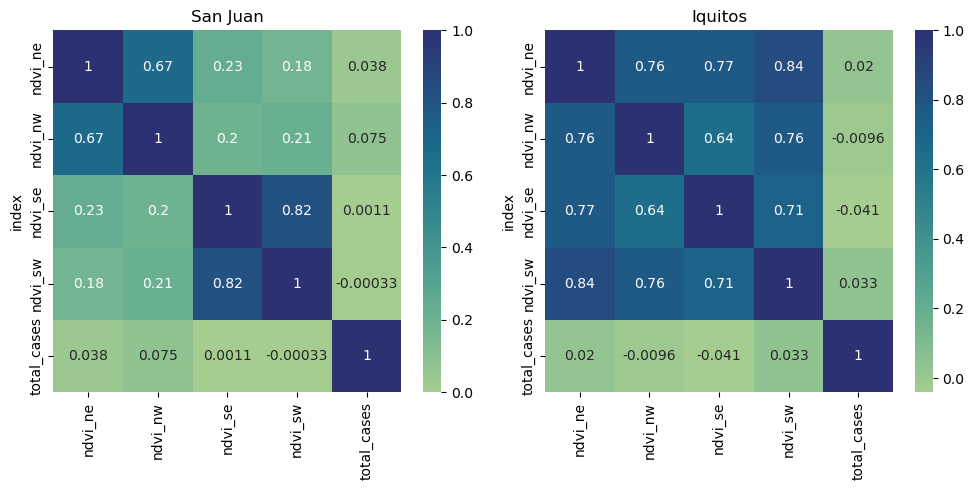

In [17]:
corr_heatmap('ndvi',ndvi,10,5)
matplotlib.rc_file_defaults()

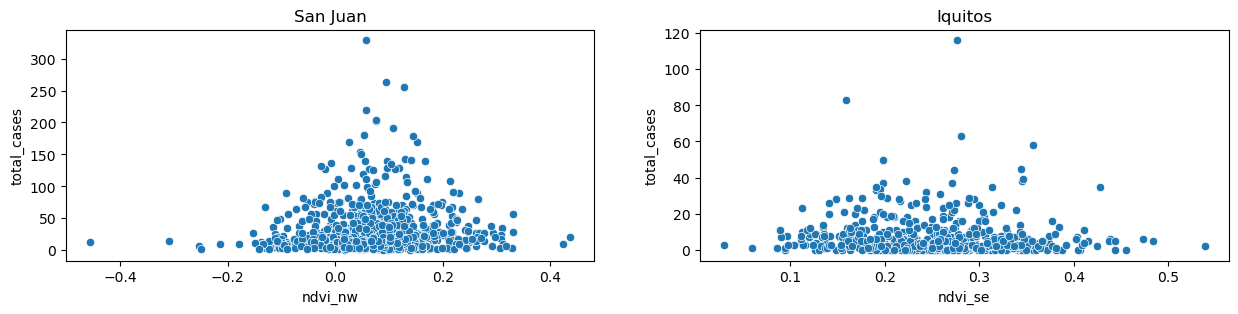

In [18]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(x="ndvi_nw", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="ndvi_se", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Reanalysis 

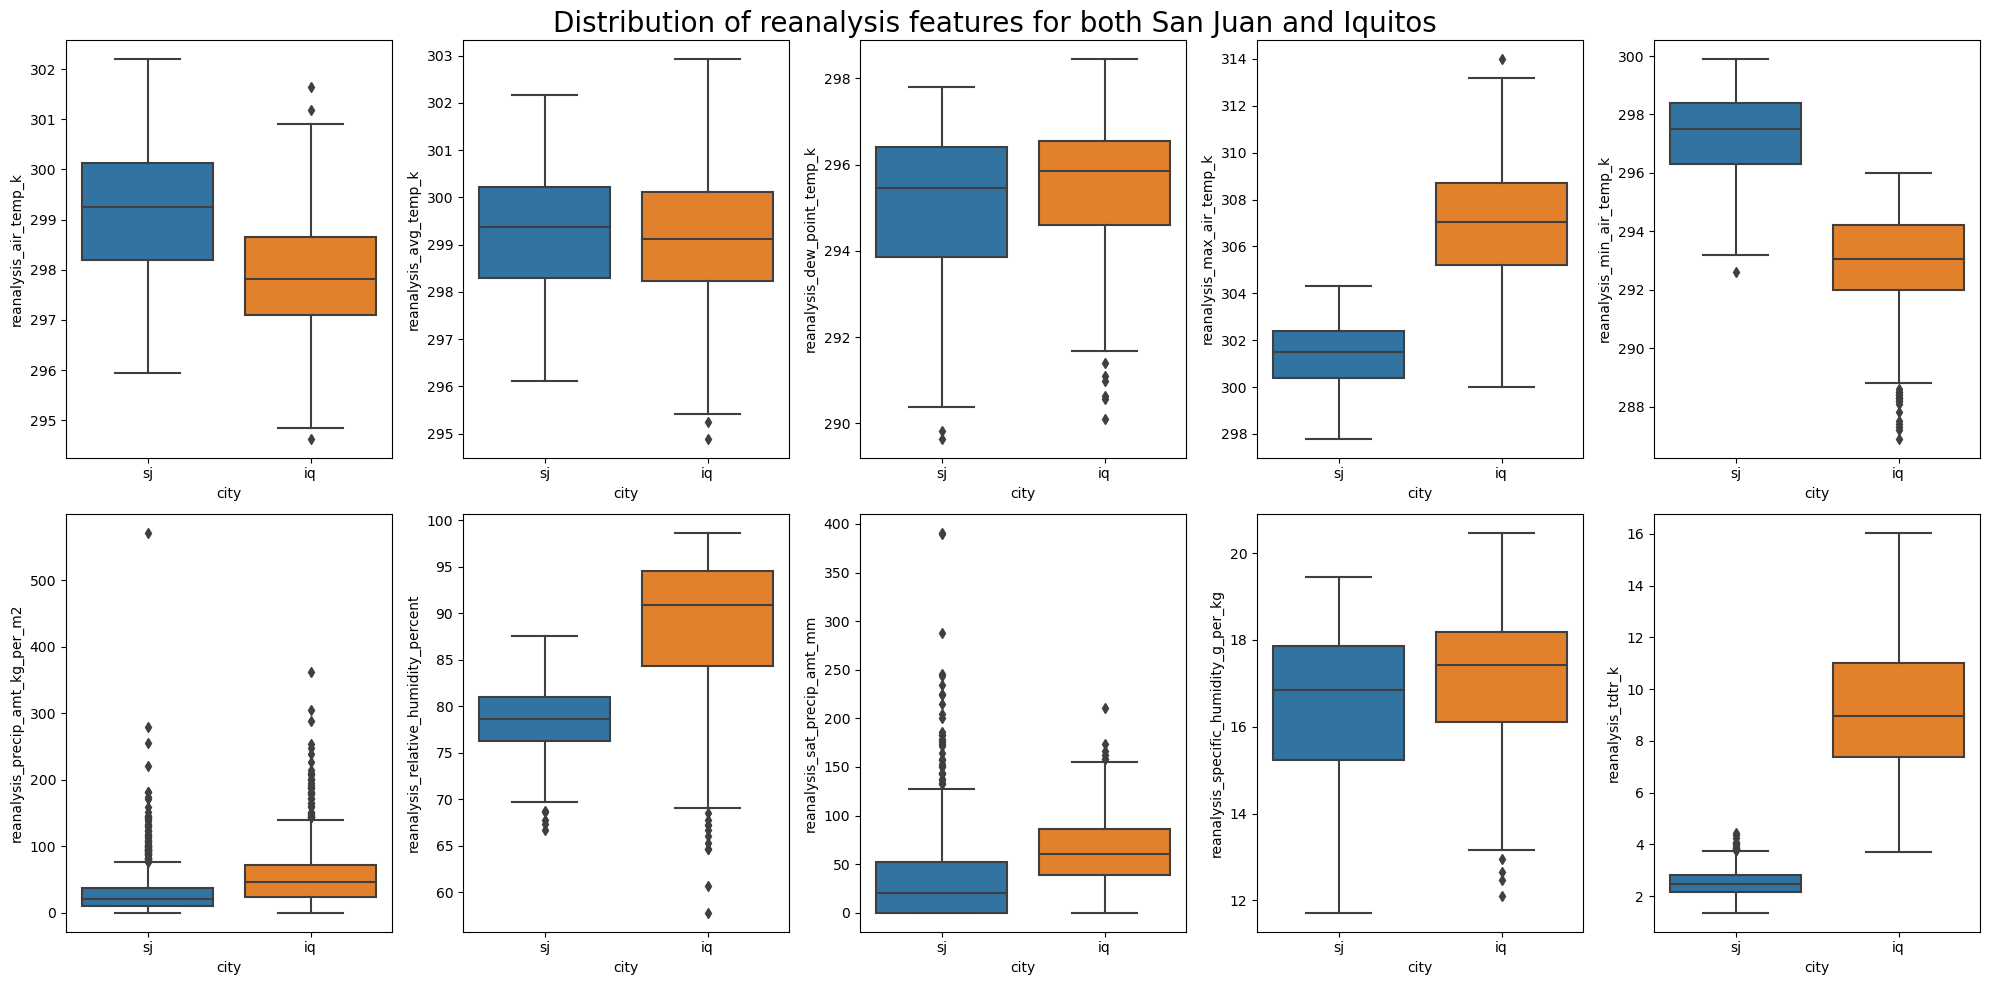

In [19]:
plot_distributions(reanalysis,20,10,20,2,5,'reanalysis')

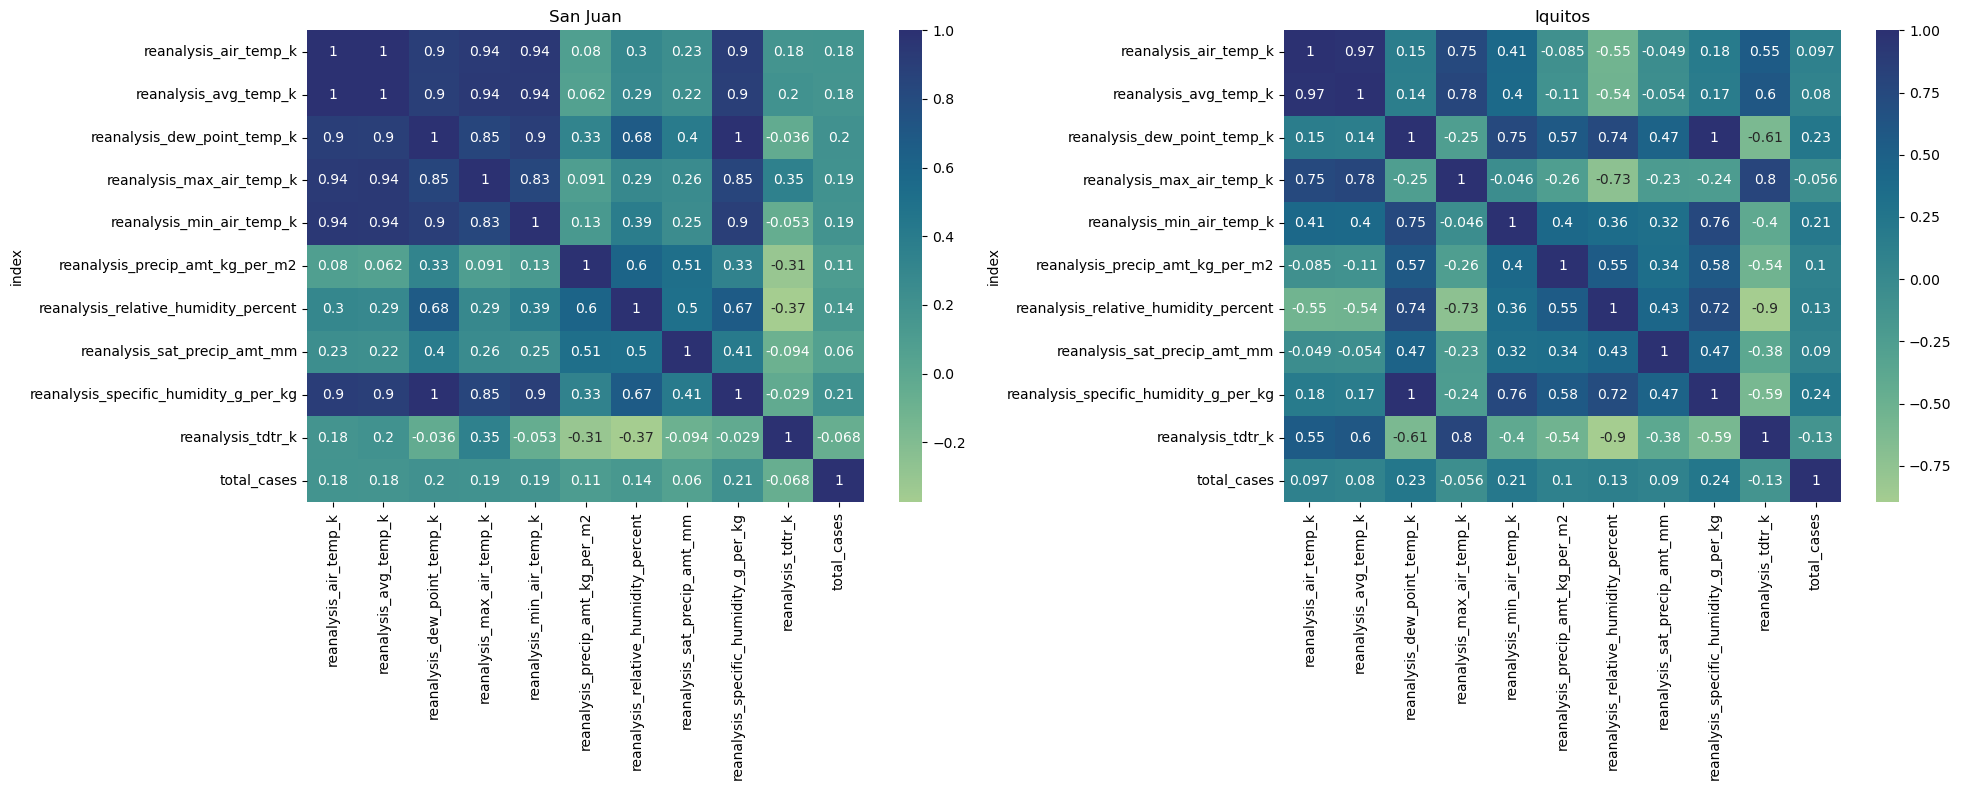

In [20]:
var = 'reanalysis'
var_list = reanalysis
corr_heatmap('reanalysis',reanalysis,20,8)
matplotlib.rc_file_defaults()

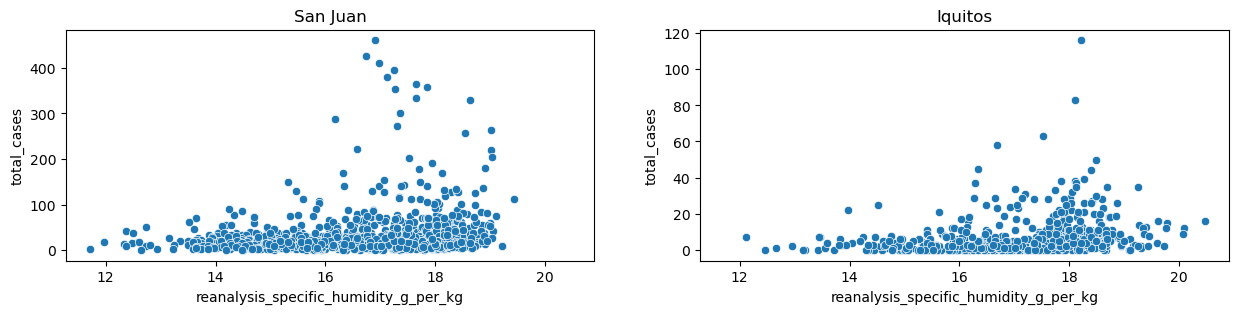

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Precipitation

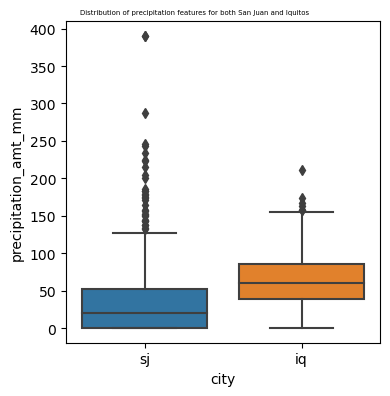

In [22]:
plot_distributions(precip,4,4,5,1,1,'precipitation')

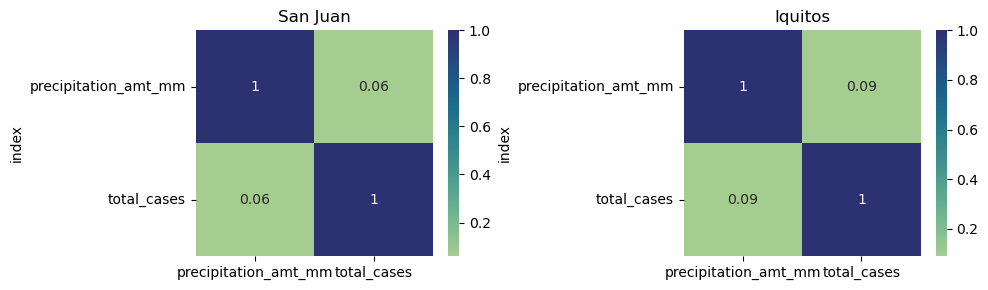

In [23]:
corr_heatmap('precipitation',precip,10,3)
matplotlib.rc_file_defaults()

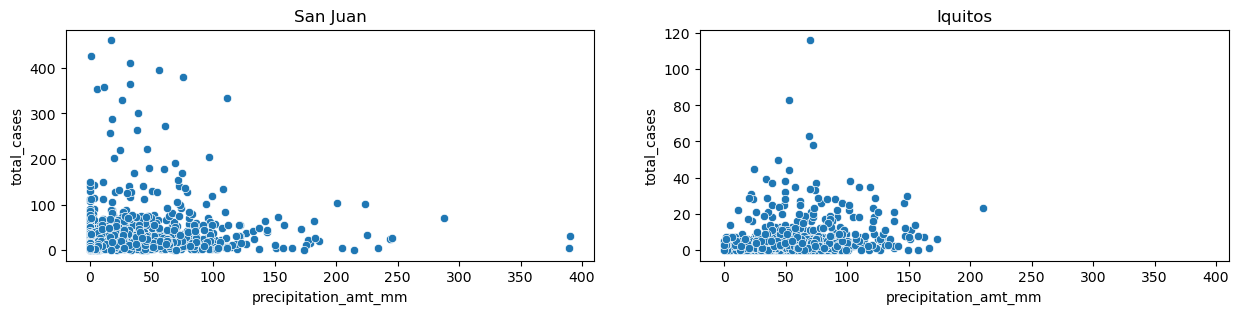

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Climate

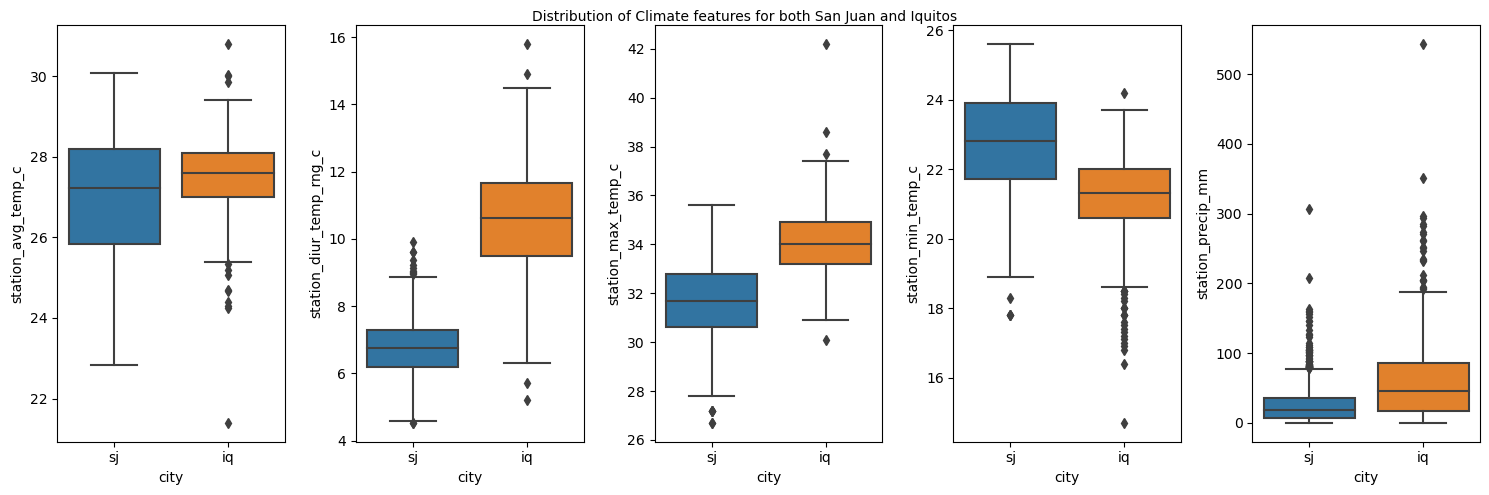

In [25]:
plot_distributions(station,15,5,10,1,5,'Climate')

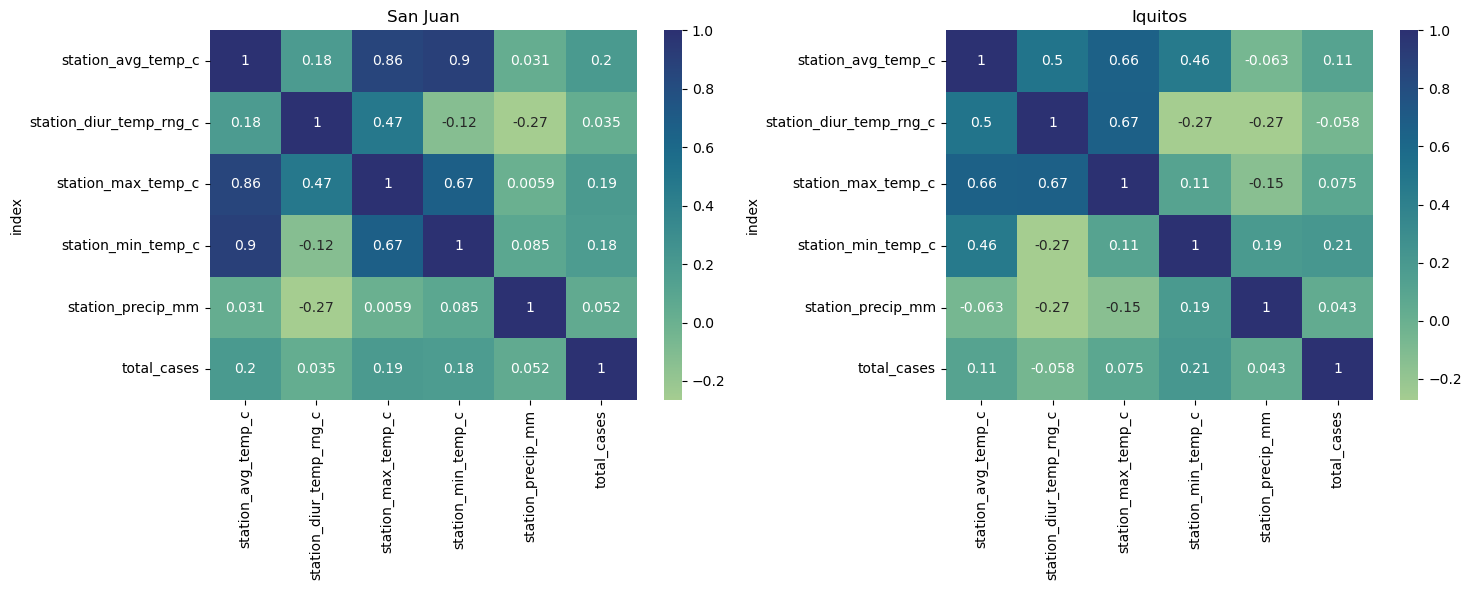

In [26]:
corr_heatmap('station',station,15,6)
matplotlib.rc_file_defaults()

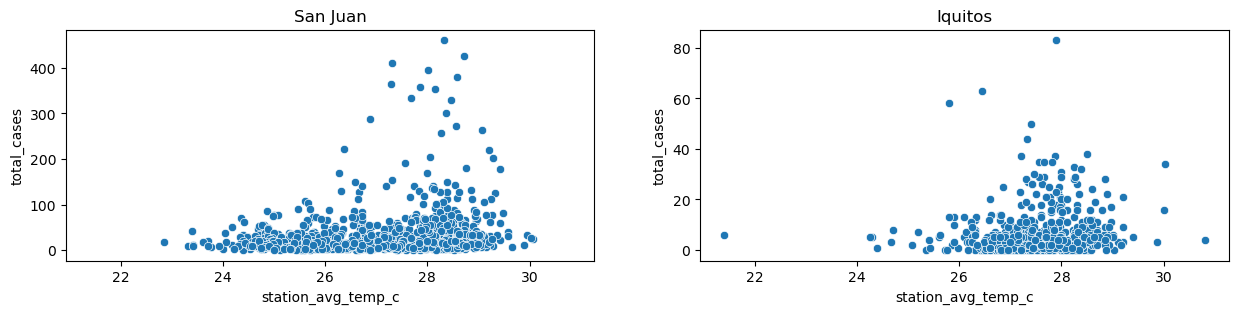

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

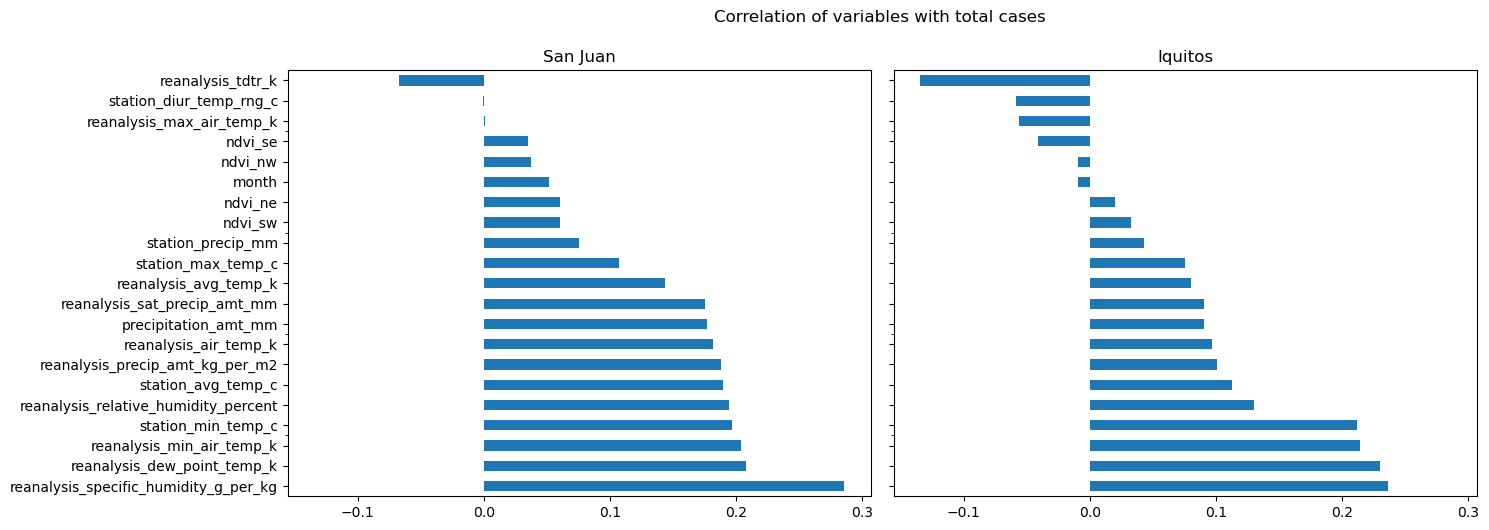

In [28]:
# reference: https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb
fig, axs = plt.subplots(1,2, figsize=(15,5),sharey=True,sharex=True)
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[0]))
axs[0].title.set_text('San Juan');
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[1]))
axs[1].title.set_text('Iquitos');
fig.tight_layout();
fig.suptitle('Correlation of variables with total cases',x=0.59,y=1.05);

### Sanity Checks

In [29]:
### there are no unique values set as a placeholder for missing values e.g. -9999
display(df_train_features['precipitation_amt_mm'].value_counts(1).sort_index(ascending=False).reset_index().loc[0:2,])
display(df_train_features['station_precip_mm'].value_counts(1).sort_index(ascending=False).reset_index().loc[0:2,])

,index,precipitation_amt_mm
0,390.60,0.000693
1,389.60,0.000693
2,287.55,0.000693


,index,station_precip_mm
0,543.3,0.000697
1,350.9,0.000697
2,305.9,0.000697


In [30]:
## See if there are longer than 9 days of gaps in the data (making sure that we have weekly data)
dg = df_train_features.copy()
dg['diff'] = pd.to_datetime(df_train_features['week_start_date']).diff().dt.days
dg.loc[dg['diff']>9,['city', 'year','week_start_date','diff']]

,city,year,week_start_date,diff


In [31]:
print('San Juan')
#any year with 0 cases?
display(pd.DataFrame(df_train_labels_sj.groupby('year')['total_cases'].sum()).transpose())
#check for the year that has lowest number of cases. How many weeks of data do we have for that year
display(df_train_labels_sj.loc[df_train_labels_sj['year']==2008,['year','weekofyear','total_cases']].reset_index(drop=True).transpose());

San Juan


year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
year,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008
weekofyear,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
total_cases,15,14,15,10,9,2,6,8,5,1,2,3,4,3,1,3,5


In [32]:
print('Iquitos')
#any year with 0 cases?
display(pd.DataFrame(df_train_labels_iq.groupby('year')['total_cases'].sum()).transpose())
#check for the year that has lowest number of cases. How many weeks of data do we have for that year
display(df_train_labels_iq.loc[df_train_labels_iq['year']==2000,['year','weekofyear','total_cases']].reset_index(drop=True).transpose());

Iquitos


year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
total_cases,4,14,704,114,638,311,436,365,801,324,223


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
year,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
weekofyear,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
total_cases,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [33]:
percent_missing_sj = 100*df_train_features_sj.isnull().sum()/len(df_train_features_sj)
percent_missing_iq = 100*df_train_features_iq.isnull().sum()/len(df_train_features_iq)
df_missing_stats = pd.DataFrame({'precent_missing_sj' : percent_missing_sj, 
                                 'precent_missing_iq' : percent_missing_iq})
df_missing_stats.transpose()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
precent_missing_sj,0.0,0.0,0.0,0.0,0.0,20.405983,5.235043,2.029915,2.029915,0.961538,...,0.641026,0.961538,0.641026,0.641026,0.641026,0.641026,0.641026,0.641026,0.641026,0.0
precent_missing_iq,0.0,0.0,0.0,0.0,0.0,0.576923,0.576923,0.576923,0.576923,0.769231,...,0.769231,0.769231,0.769231,0.769231,7.115385,7.115385,2.692308,1.538462,3.076923,0.0


#### Year on year plot for ndvi_ne for San Juan

ndvi_ne is mostly missing for San Juan in year 1994 after 35th week

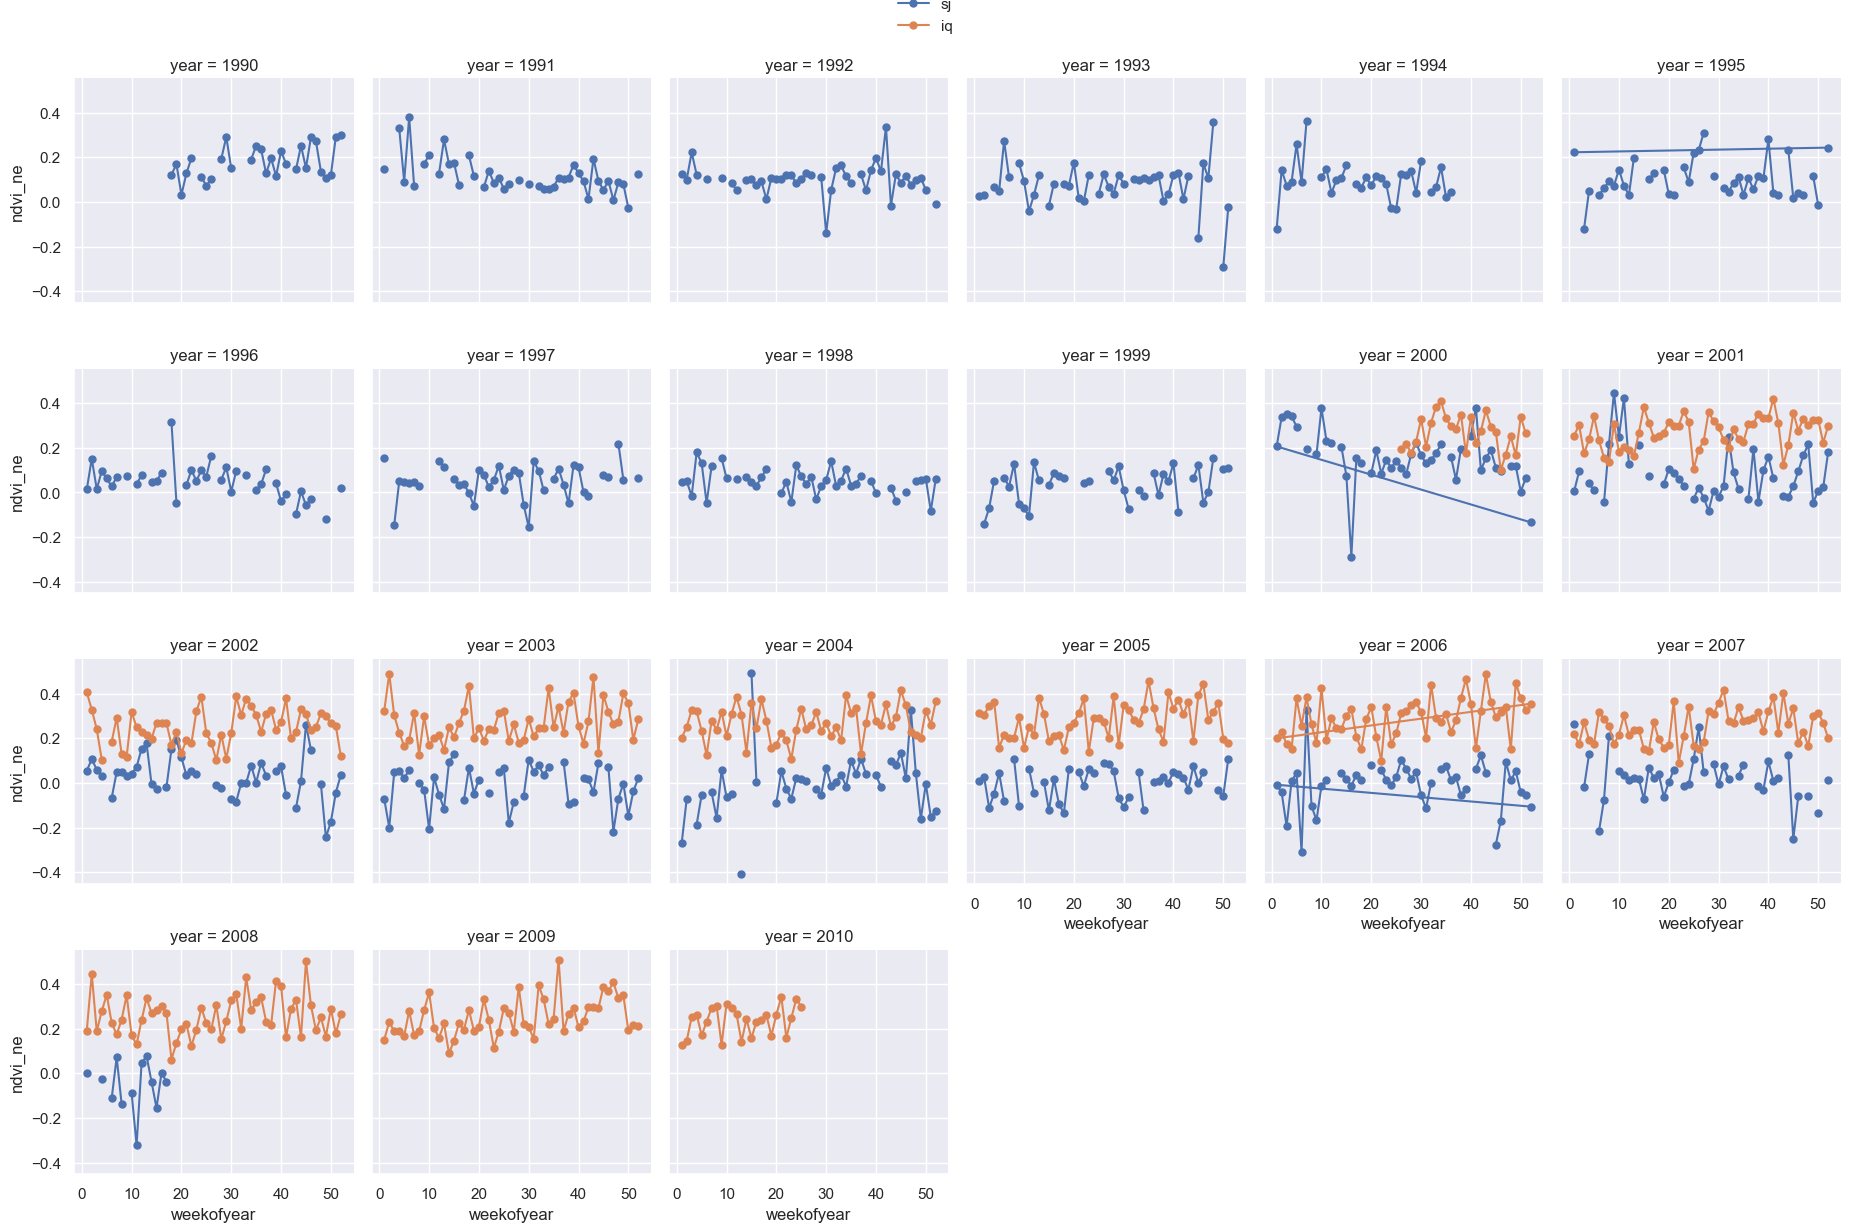

In [34]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','ndvi_ne', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

ndvi_ne has 20% missing values for SJ so we will look at that. From the graph we see that year 1994 is missing after 35th week

Text(0.5, 1.0, 'ndvi_ne for San Juan for year 1994')

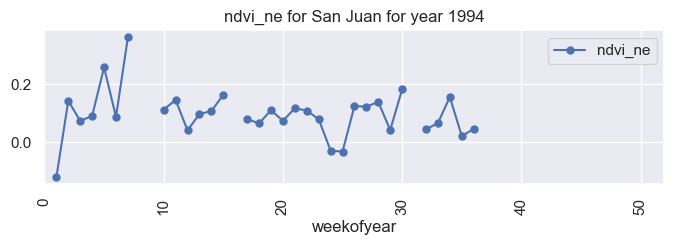

In [35]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_sj.loc[(df_train_features_sj['year']==1994),][['weekofyear','ndvi_ne']].plot(x='weekofyear',y='ndvi_ne',rot=90,marker = '.', markersize = 10)
plt.xlim((0,52))
plt.title('ndvi_ne for San Juan for year 1994')

#### Year on year plot for station_avg_temp_c for Iquitos

station_avg_temp_c has 7% missing values for IQ so we will look at that. From the graph we see that year 2008 is the most problematic from 23rd to 30th week

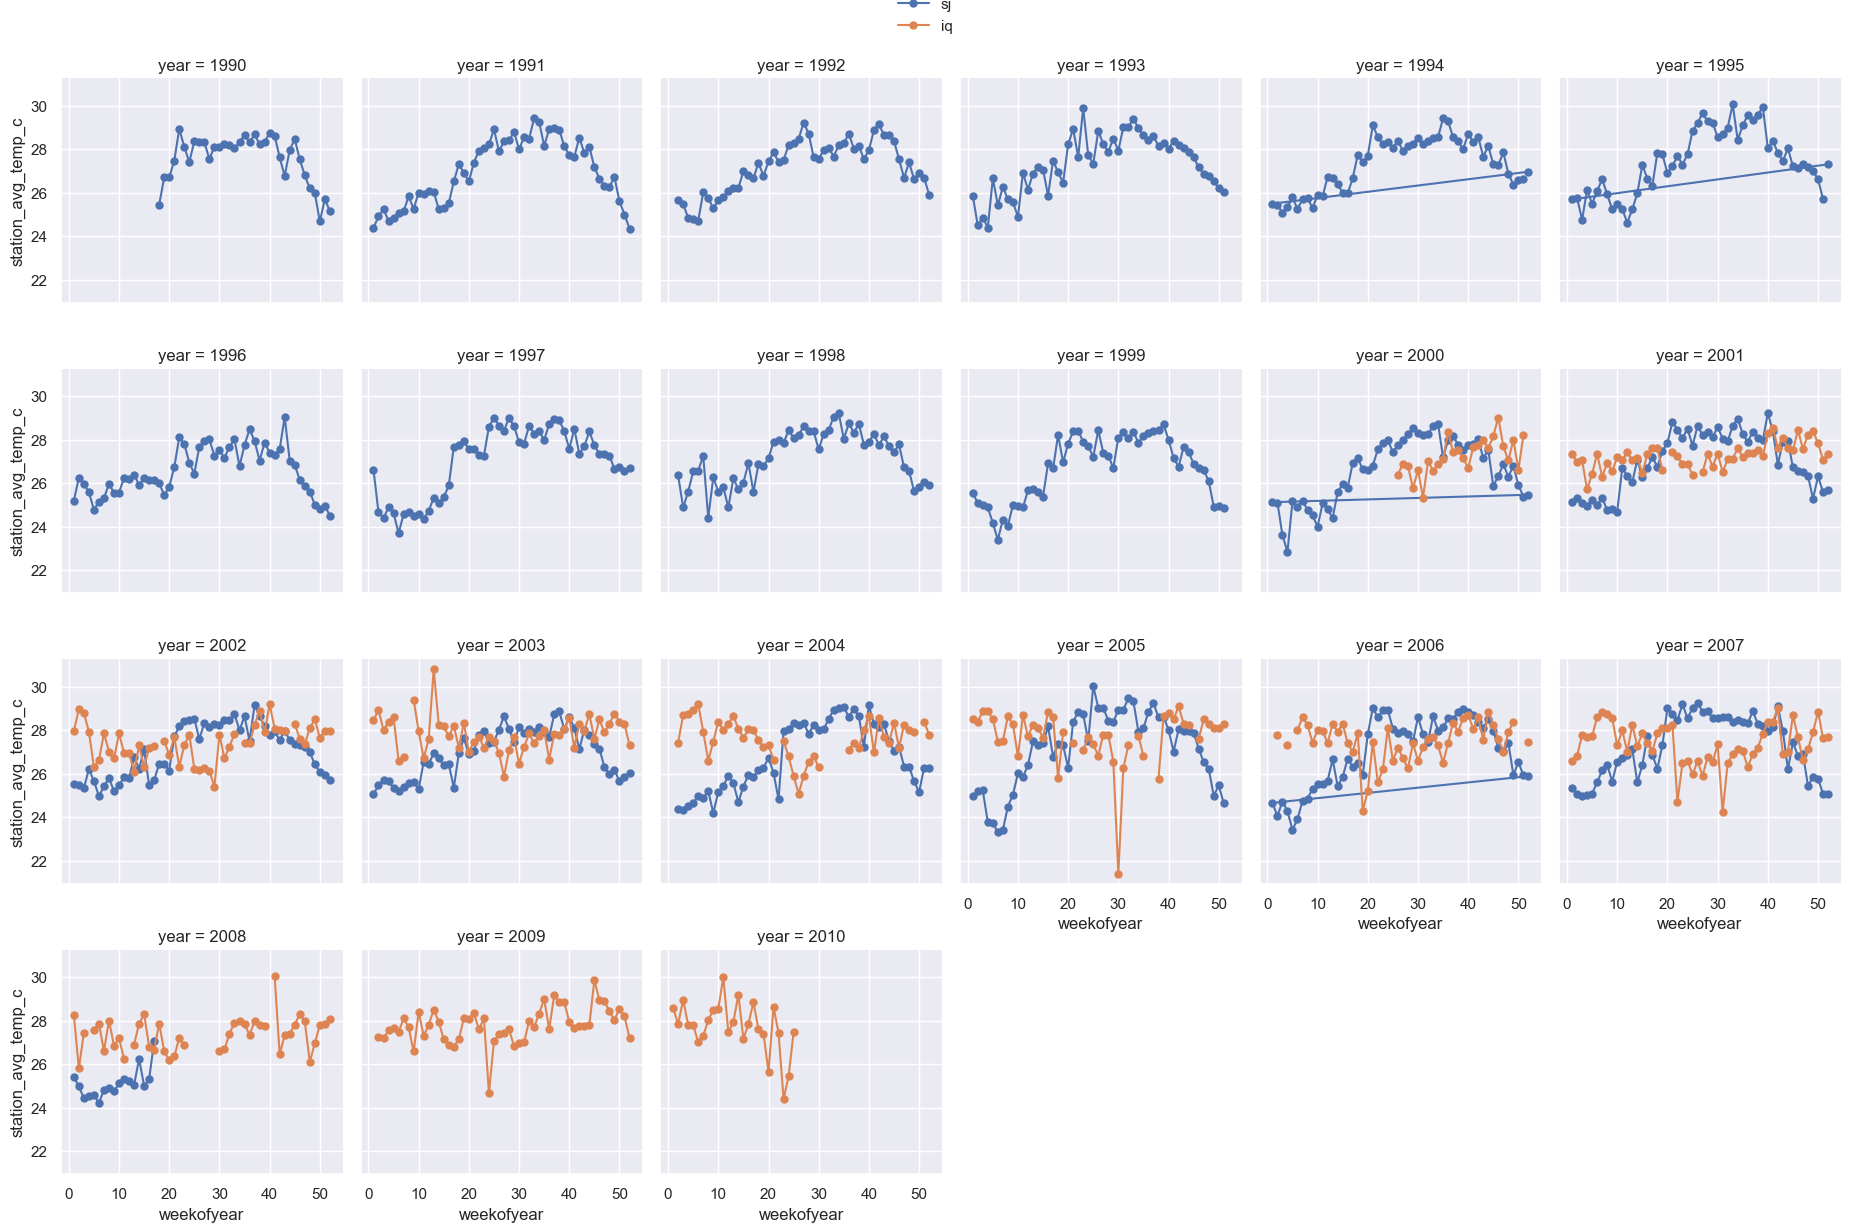

In [36]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','station_avg_temp_c', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'station_avg_temp_c for Iquitos for year 2008')

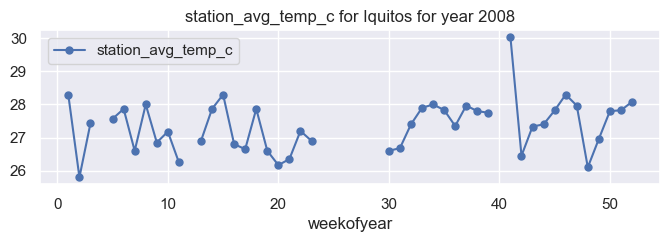

In [37]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_iq.loc[(df_train_features_iq['year']==2008),][['weekofyear','station_avg_temp_c']].plot(x='weekofyear',y='station_avg_temp_c',marker = '.', markersize = 10)
plt.title('station_avg_temp_c for Iquitos for year 2008')

### Filling in Missing Values

Filling in all values with more than 1% missing values with ARIMA forecaster. Otherwise forward fill is used 

In [38]:
for i in range(len(useable_features)):
    if (df_missing_stats.reset_index().loc[df_missing_stats.reset_index()['index']==useable_features[i],'precent_missing_sj'].values[0] > 1):
        print(useable_features[i])
        result = adfuller(df_train_features_sj.loc[:,useable_features[i]].dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

ndvi_ne
ADF Statistic: -5.125328
p-value: 0.000012
ndvi_nw
ADF Statistic: -2.892267
p-value: 0.046255
ndvi_se
ADF Statistic: -9.594164
p-value: 0.000000
ndvi_sw
ADF Statistic: -9.865577
p-value: 0.000000


In [39]:
for i in range(len(useable_features)):
    if (df_missing_stats.reset_index().loc[df_missing_stats.reset_index()['index']==useable_features[i],'precent_missing_iq'].values[0] > 1):
        print(useable_features[i])
        result = adfuller(df_train_features_iq.loc[:,useable_features[i]].dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

station_avg_temp_c
ADF Statistic: -6.072770
p-value: 0.000000
station_diur_temp_rng_c
ADF Statistic: -6.140134
p-value: 0.000000
station_max_temp_c
ADF Statistic: -7.501546
p-value: 0.000000
station_min_temp_c
ADF Statistic: -5.387557
p-value: 0.000004
station_precip_mm
ADF Statistic: -5.981924
p-value: 0.000000


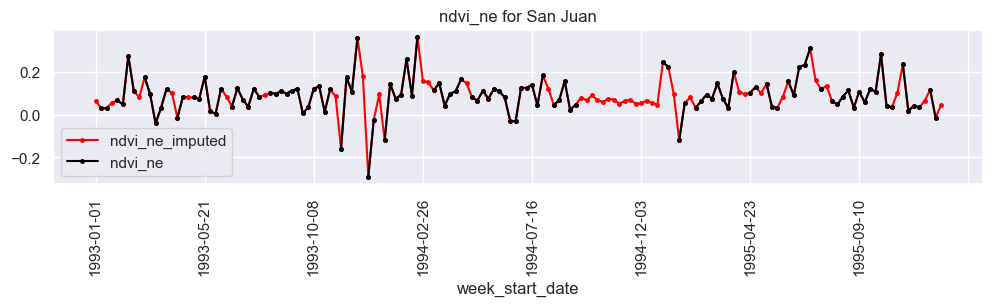

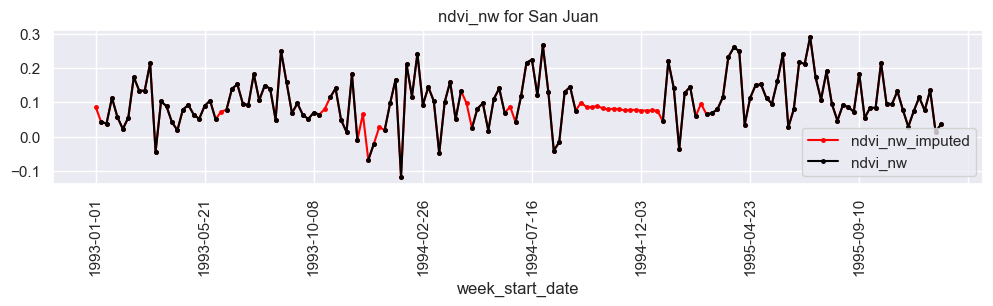

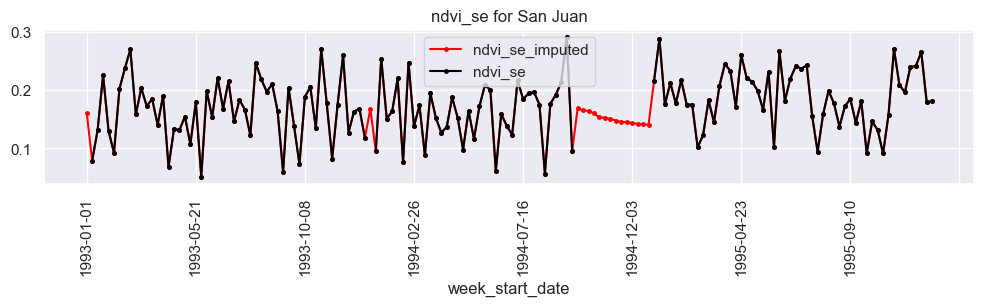

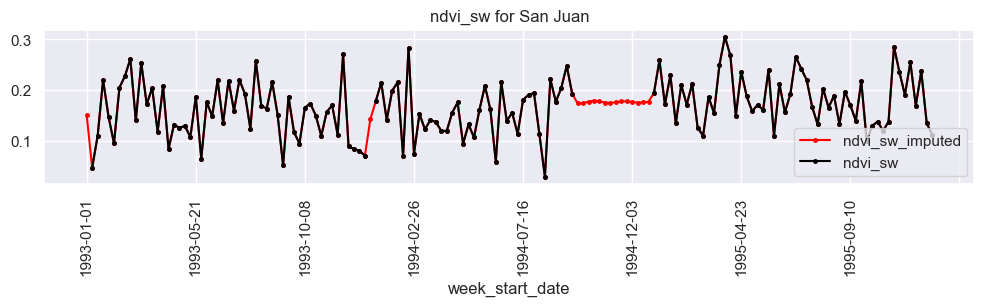

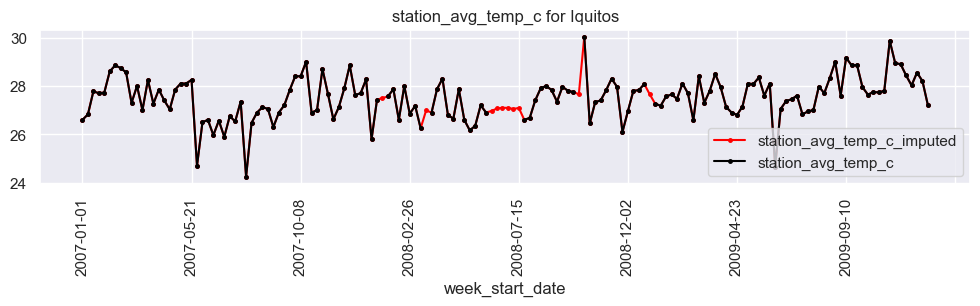

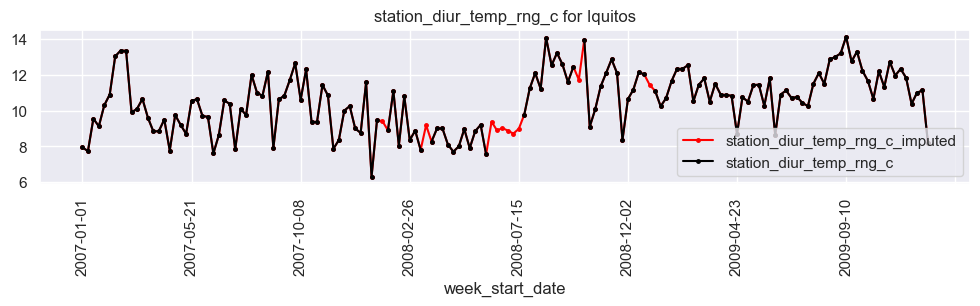

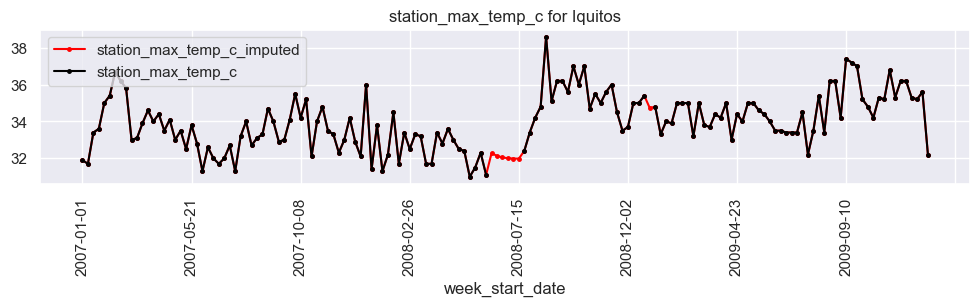

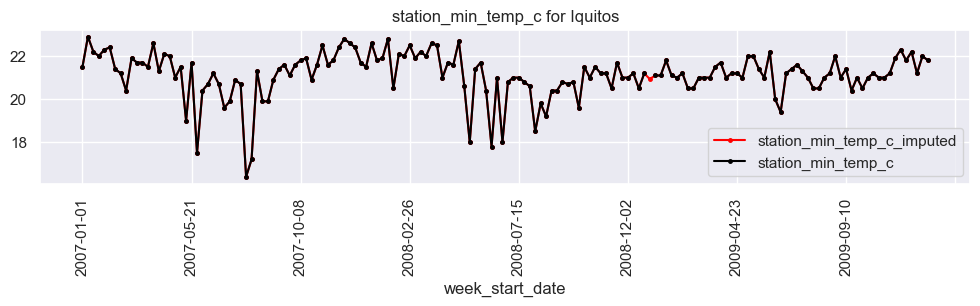

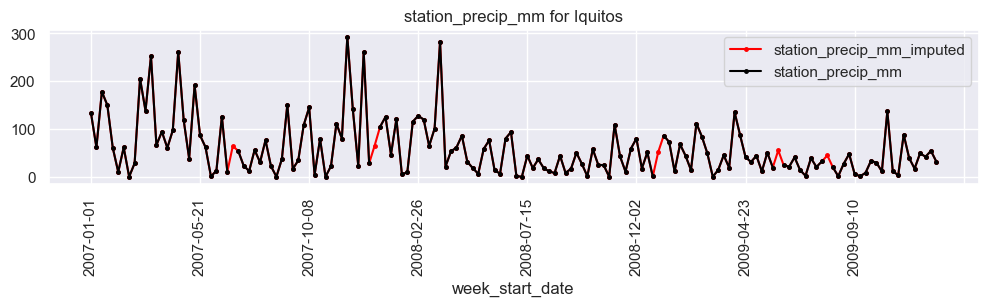

In [40]:
missing_threshold = 1
forecaster= ARIMA((4,0,4), suppress_warnings=True)

def impute(df,colname, plot_graphs=True):
    for i in range(len(df.columns)):
        #SELECTING VARIABLE TO IMPUTE
        var = df_missing_stats.reset_index().iloc[i,0]
        
        #IF IT'S MISSING PERCENTAGE IS > MISSING THRESHOLD THEN USE FORECASTER
        if (df_missing_stats.reset_index().loc[i,colname] > missing_threshold):
            transformer = Imputer(method="forecaster",forecaster=forecaster) #ARIMA FORECASTER
            df.loc[:,var+'_imputed'] = transformer.fit_transform(df.loc[:,var])
            
            
            #PLOTTING VEGETATION FIELDS FOR SAN JUAN
            if plot_graphs:
                if 'ndvi' in var and 'sj' in colname :
                    fig, ax = plt.subplots(figsize=(12,2));
                    plt.title(var+' for San Juan')
                    df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                    df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)

                #PLOTTING STATION FIELDS FOR IQUITOS
                if 'station' in var and 'iq' in colname :
                    fig, ax = plt.subplots(figsize=(12,2));
                    plt.title(var+' for Iquitos')
                    df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                    df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)
            df.drop(var, axis=1,inplace=True)
            df.loc[:,var] = df.loc[:,var+'_imputed']
            df.drop(var+'_imputed', axis=1,inplace=True)
        #IF MISSING % IS LESS THAN MISSING THRESHOLD THEN USE FORWARD FILL
        elif (df_missing_stats.reset_index().loc[i,colname] > 0) :
            df.loc[:,var] = df[var].fillna(method="ffill")
    return df


df_train_features_sj_imputed = impute(df_train_features_sj.copy(),'precent_missing_sj')
df_train_features_iq_imputed = impute(df_train_features_iq.copy(),'precent_missing_iq')
df_train_features_imputed = pd.concat([df_train_features_sj_imputed,df_train_features_iq_imputed])

### Train Test Split preparation

In [41]:
def hold_out_set(df_features,df_labels,label_col,split):
    all_features = df_features.columns
    train_size = int(len(df_features) * split)
    test_size = len(df_features) - train_size
    X_train, X_test = df_features.loc[0:train_size,all_features], df_features.loc[train_size:len(df_features),all_features]
    y_train, y_test = df_labels.loc[0:train_size,label_col], df_labels.loc[train_size:len(df_labels),label_col]
    #print('Train data: ', X_train.shape)
    #print('Test data: ', X_test.shape)
    
    return X_train, X_test, y_train, y_test

### Feature Importance from Random Forest (Using current week's data to predict number of cases)

Mean Absolute Error: 8
Mean Absolute Error: 29


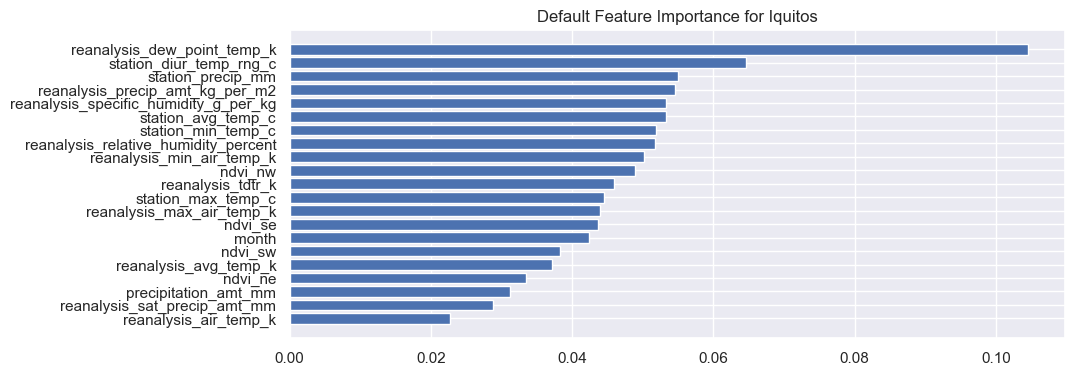

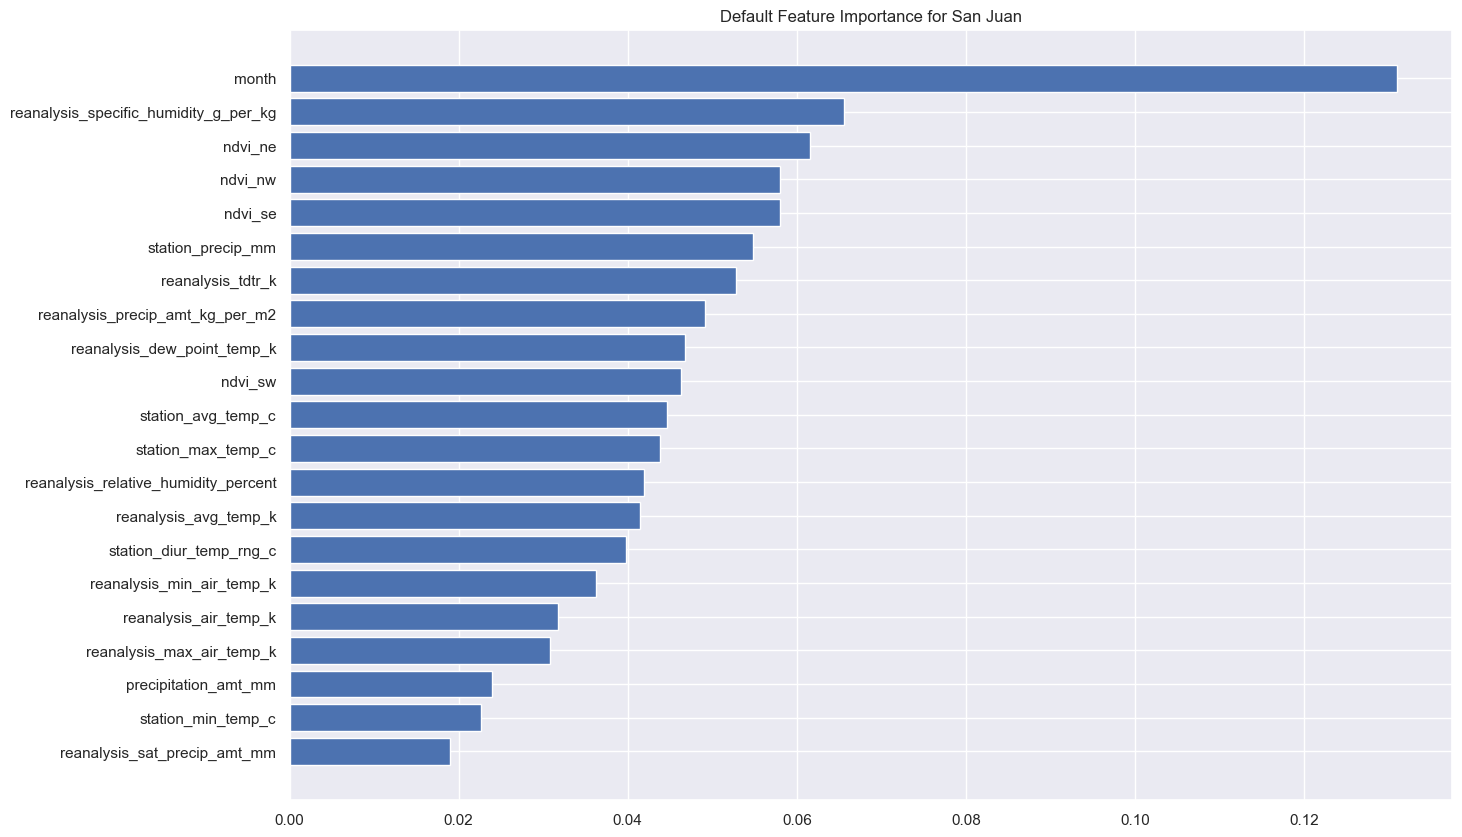

In [42]:
def feature_importance(df_train,df_labels,label_col,ttl,split):
    X_train, X_test, y_train, y_test = hold_out_set(df_train,df_labels,label_col,split)
    rf= RandomForestRegressor(n_estimators=100,criterion='absolute_error')
    split = TimeSeriesSplit(n_splits=5)
    score= cross_val_score(rf, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf.fit(X_train, y_train)
    sorted_idx = rf.feature_importances_.argsort()
    all_features = X_train.columns
    g = plt.barh(all_features[sorted_idx], rf.feature_importances_[sorted_idx])
    plt.title('Default Feature Importance for '+ttl)
    
    #perm_importance = permutation_importance(rf, X_test, y_test)
    #sorted_idx = perm_importance.importances_mean.argsort()
    #g = plt.barh(all_features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    #plt.xlabel("Permutation Importance")
    top_10_features = list(all_features[sorted_idx][-10:])

    predictions = rf.predict(X_test)
    errors = abs(predictions - y_test)
    print('Mean Absolute Error:', math.floor(np.mean(errors)))
    return rf,g,top_10_features


plt.figure(figsize=(10,4))
rf_iq_static, g, top_10_features_iq_static = feature_importance(df_train_features_iq_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),  
                                           df_train_labels_iq,'total_cases',
                                           'Iquitos',0.70)
plt.figure(figsize=(15,10))
rf_sj_static,g,top_10_features_sj_static = feature_importance(df_train_features_sj_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1), 
                                          df_train_labels_sj,'total_cases',
                                          'San Juan',0.70)


### Cross validation using different models

In [43]:
def pipeline_cross_val(df_features, df_labels,col,label='total_cases',split=0.70):
    X_train, X_test, y_train, y_test = hold_out_set(df_features,df_labels,label,split)

    split = TimeSeriesSplit(n_splits=5)
    models = { 'Linear Regression': make_pipeline(StandardScaler(),linear_model.LinearRegression()),
             'RF': RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=4),
             'SVR': make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5)),
             'Poisson Regressor': make_pipeline(StandardScaler(),linear_model.PoissonRegressor(warm_start=True)),
             'Bayesian Ridge': make_pipeline(StandardScaler(),linear_model.BayesianRidge()),
             'Lasso': make_pipeline(StandardScaler(),linear_model.LassoLars(alpha=.1, normalize=False))}
    train_scores = {}
    test_scores = {}

    best_score = -999999
    for key, value in models.items():
        score= cross_val_score(value, X_train,y_train, cv=split, 
                               scoring='neg_mean_absolute_error')
        value.fit(X_train, y_train)
        train_scores[key] = abs(score[-1])
        y_pred = value.predict(X_test)
        test_scores[key] = mae(y_test, y_pred)

    return pd.DataFrame.from_dict(train_scores, orient = 'index',columns=[col[0]]).join(pd.DataFrame.from_dict(test_scores, orient = 'index',columns=[col[1]]))  

### Prediction for San Juan using static data

San Juan:
Forward Filled Data:
Data imputed with ARIMA:
Only top 10 features used:


,trainScore_FFill,testScore_FFill,trainScore_ARIMA,testScore_ARIMA,trainScore_top10features,testScore_top10features
Linear Regression,32.155523,30.552846,31.586245,26.866915,29.937191,27.299427
RF,19.655872,21.036174,19.883670,20.361922,17.914954,20.912224
SVR,16.597704,17.418403,16.761577,17.310263,16.241334,17.264395
Poisson Regressor,26.290441,27.212807,28.281173,25.364448,29.672512,26.972049
Bayesian Ridge,29.175874,29.440336,29.094165,25.774608,29.259608,26.752983
Lasso,29.704548,28.652086,29.581834,25.415655,29.627713,27.196027


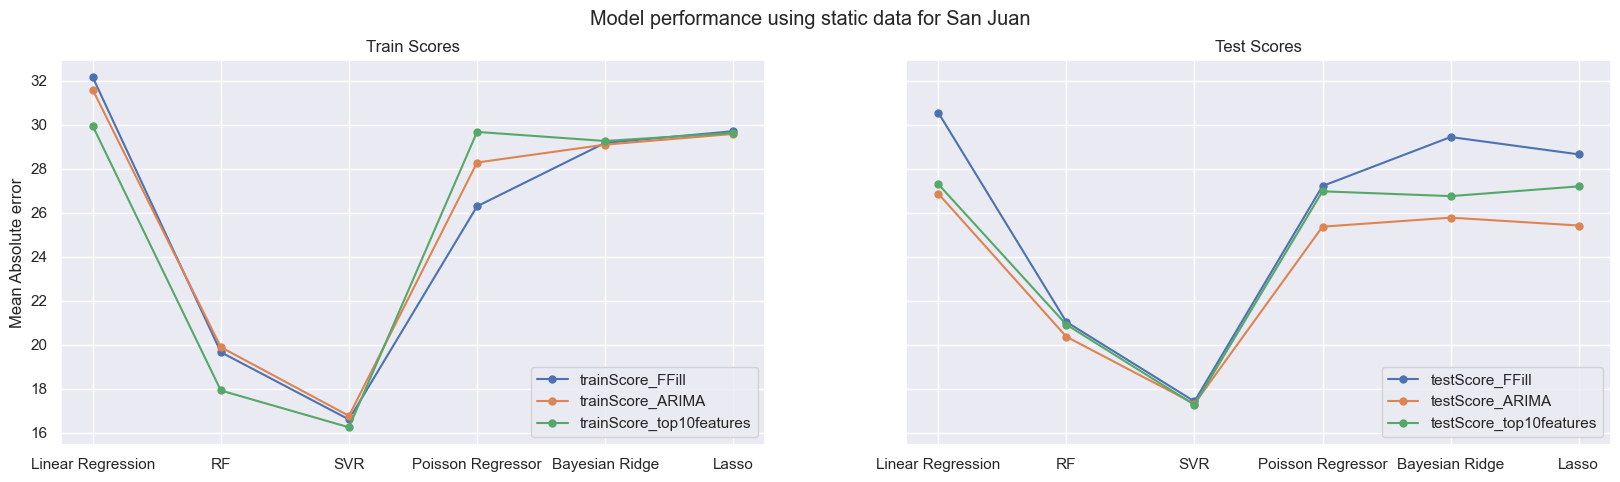

In [44]:
print('San Juan:')
print('Forward Filled Data:')
df_ffill = pipeline_cross_val(df_train_features_sj.fillna(method="ffill").drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_sj,['trainScore_FFill','testScore_FFill'])

print('Data imputed with ARIMA:')
df_arima = pipeline_cross_val(df_train_features_sj_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_sj,['trainScore_ARIMA','testScore_ARIMA'])


print('Only top 10 features used:')
df_top10 = pipeline_cross_val(df_train_features_sj_imputed[top_10_features_sj_static],
                   df_train_labels_sj,['trainScore_top10features','testScore_top10features'])
display(pd.concat([df_ffill,df_arima,df_top10],axis=1))

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)
df = pd.concat([df_ffill,df_arima,df_top10],axis=1)
df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Prediction for Iquitos using static data

Iquitos:
Forward Filled Data:
Data imputed with ARIMA:
Only top 10 features used:


,trainScore_FFill,testScore_FFill,trainScore_ARIMA,testScore_ARIMA,trainScore_top10features,testScore_top10features
Linear Regression,4.252952,7.733572,4.200168,7.717926,4.048160,7.300599
RF,3.566333,7.783494,3.274750,7.591218,2.986250,7.697051
SVR,2.644733,7.405613,2.650721,7.369591,2.904568,7.574527
Poisson Regressor,4.214571,7.596432,4.136256,7.589497,3.983751,7.369612
Bayesian Ridge,3.833804,7.522491,3.802105,7.521272,3.782958,7.384278
Lasso,4.095699,7.759469,4.005537,7.690038,4.063530,7.440388


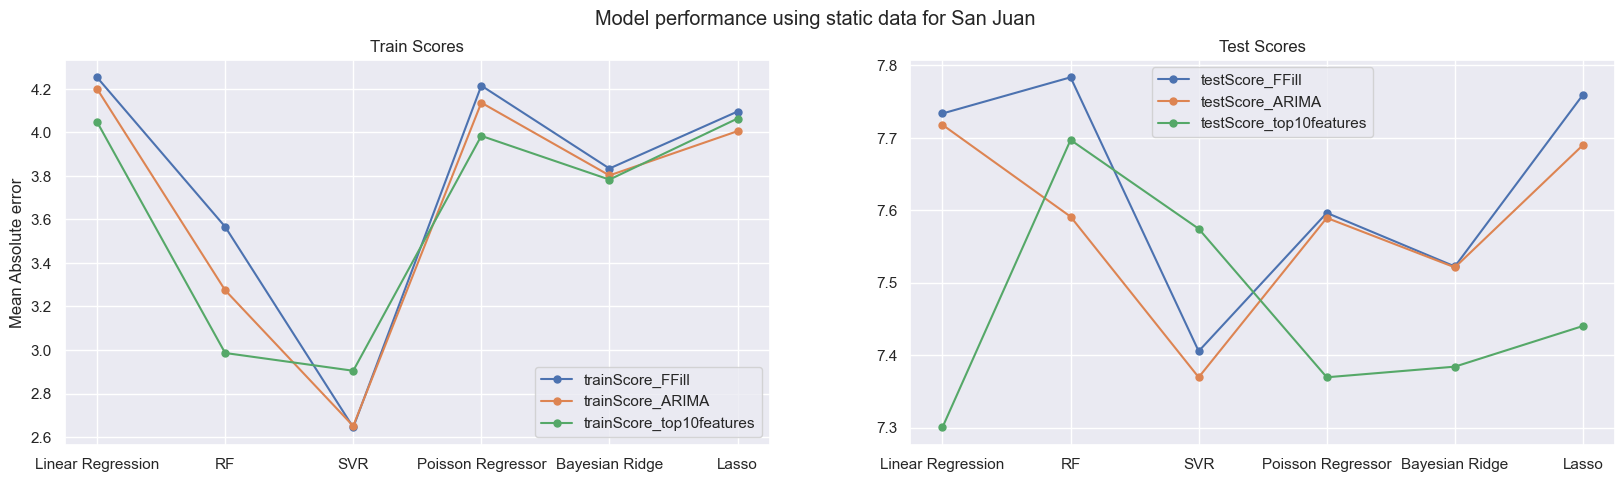

In [45]:
print('Iquitos:')
print('Forward Filled Data:')
df_ffill = pipeline_cross_val(df_train_features_iq.fillna(method="ffill").drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_iq,['trainScore_FFill','testScore_FFill'])

print('Data imputed with ARIMA:')
df_arima = pipeline_cross_val(df_train_features_iq_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_iq,['trainScore_ARIMA','testScore_ARIMA'])


print('Only top 10 features used:')
df_top10 = pipeline_cross_val(df_train_features_iq_imputed[top_10_features_iq_static],
                   df_train_labels_iq,['trainScore_top10features','testScore_top10features'])
display(pd.concat([df_ffill,df_arima,df_top10],axis=1))

fig, axs = plt.subplots(1,2, sharex=True)
df = pd.concat([df_ffill,df_arima,df_top10],axis=1)
df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Time series forecasting

#### Prepare data

In [46]:
def window_function(df,features,target,lag,lead):
    lagged_cols, lagged_col_names = list(), list()
    for i in range(lag, 0, -1):
        lagged_cols.append(df.drop(target,axis=1).shift(i))
        lagged_col_names += [('%s(t-%d)' % (j, i)) for j in features]
    
    for i in range(0, lead):
        lagged_cols.append(df[target].shift(-i).fillna(0).astype(int))
        if i == 0:
            lagged_cols.append(df.drop(target,axis=1).shift(-i))
            lagged_col_names += [(target+'(t)')]
            lagged_col_names += [('%s(t)' % j) for j in features]
        else:
            lagged_cols.append(df.drop(target,axis=1).shift(-i))
            lagged_col_names += [('%s(t+1)' % (j,i)) for j in features]
        
    shifted_df = pd.concat(lagged_cols, axis=1)
    shifted_df.columns = lagged_col_names
    shifted_df.dropna(inplace=True)
    return shifted_df

Using last week's data and current week's data to predict current week's number of dengue cases.<br>
<br>
e.g:
<br>
**FEATURES:**<br>
ndvi_ne(t-1) = Last week's vegetation index <br>
ndvi_ne(t) = This week's vegetation index <br>

<br>
<br>
**TARGET:**<br>
no_of_cases(t) : This week's dengue cases

In [47]:
df_sj_time_series = df_train_features_sj_imputed.loc[:,top_10_features_sj_static]
df_sj_time_series['no_of_cases'] = df_train_labels_sj.loc[:,'total_cases']
df_sj_time_series = window_function(df_sj_time_series,top_10_features_sj_static, 'no_of_cases',1,1)
example_cols_present = [x for x in df_sj_time_series.columns if '(t)' in x]
example_cols_past = [x for x in df_sj_time_series.columns if '(t-1)' in x]
df_sj_time_series.head()

,ndvi_sw(t-1),reanalysis_dew_point_temp_k(t-1),reanalysis_precip_amt_kg_per_m2(t-1),reanalysis_tdtr_k(t-1),station_precip_mm(t-1),ndvi_se(t-1),ndvi_nw(t-1),ndvi_ne(t-1),reanalysis_specific_humidity_g_per_kg(t-1),month(t-1),...,ndvi_sw(t),reanalysis_dew_point_temp_k(t),reanalysis_precip_amt_kg_per_m2(t),reanalysis_tdtr_k(t),station_precip_mm(t),ndvi_se(t),ndvi_nw(t),ndvi_ne(t),reanalysis_specific_humidity_g_per_kg(t),month(t)
1,0.177617,292.414286,32.00,2.628571,16.0,0.198483,0.103725,0.122600,14.012857,4.0,...,0.155486,293.951429,17.94,2.371429,8.6,0.162357,0.142175,0.169900,15.372857,5
2,0.155486,293.951429,17.94,2.371429,8.6,0.162357,0.142175,0.169900,15.372857,5.0,...,0.170843,295.434286,26.10,2.300000,41.4,0.157200,0.172967,0.032250,16.848571,5
3,0.170843,295.434286,26.10,2.300000,41.4,0.157200,0.172967,0.032250,16.848571,5.0,...,0.235886,295.310000,13.90,2.428571,4.0,0.227557,0.245067,0.128633,16.672857,5
4,0.235886,295.310000,13.90,2.428571,4.0,0.227557,0.245067,0.128633,16.672857,5.0,...,0.247340,295.821429,12.20,3.014286,5.8,0.251200,0.262200,0.196200,17.210000,5
5,0.247340,295.821429,12.20,3.014286,5.8,0.251200,0.262200,0.196200,17.210000,5.0,...,0.181743,295.851429,26.49,2.100000,39.1,0.254314,0.174850,0.111193,17.212857,6


In [48]:
df_iq_time_series = df_train_features_iq_imputed.loc[:,top_10_features_iq_static]
df_iq_time_series['no_of_cases'] = df_train_labels_iq.loc[:,'total_cases']
df_iq_time_series = window_function(df_iq_time_series,top_10_features_iq_static, 'no_of_cases',1,1)
example_cols_present = [x for x in df_iq_time_series.columns if '(t)' in x]
example_cols_past = [x for x in df_iq_time_series.columns if '(t-1)' in x]
df_iq_time_series.head()

,ndvi_nw(t-1),reanalysis_min_air_temp_k(t-1),reanalysis_relative_humidity_percent(t-1),station_min_temp_c(t-1),station_avg_temp_c(t-1),reanalysis_specific_humidity_g_per_kg(t-1),reanalysis_precip_amt_kg_per_m2(t-1),station_precip_mm(t-1),station_diur_temp_rng_c(t-1),reanalysis_dew_point_temp_k(t-1),...,ndvi_nw(t),reanalysis_min_air_temp_k(t),reanalysis_relative_humidity_percent(t),station_min_temp_c(t),station_avg_temp_c(t),reanalysis_specific_humidity_g_per_kg(t),reanalysis_precip_amt_kg_per_m2(t),station_precip_mm(t),station_diur_temp_rng_c(t),reanalysis_dew_point_temp_k(t)
1,0.132257,293.1,92.418571,20.7,26.400000,16.651429,43.19,3.0,10.775000,295.184286,...,0.276100,291.1,93.581429,20.8,26.900000,16.862857,46.00,55.6,11.566667,295.358571
2,0.276100,291.1,93.581429,20.8,26.900000,16.862857,46.00,55.6,11.566667,295.358571,...,0.173129,292.6,95.848571,20.7,26.800000,17.120000,64.77,38.1,11.466667,295.622857
3,0.173129,292.6,95.848571,20.7,26.800000,17.120000,64.77,38.1,11.466667,295.622857,...,0.145429,288.6,87.234286,14.7,25.766667,14.431429,23.96,30.0,10.533333,292.797143
4,0.145429,288.6,87.234286,14.7,25.766667,14.431429,23.96,30.0,10.533333,292.797143,...,0.322129,291.5,88.161429,19.1,26.600000,15.444286,31.80,4.0,11.480000,293.957143
5,0.322129,291.5,88.161429,19.1,26.600000,15.444286,31.80,4.0,11.480000,293.957143,...,0.190757,288.5,74.728571,17.0,25.340000,13.421429,1.00,11.5,10.940000,291.725714


### Prediction for San Juan using time series data

San Juan:
Time series Data:


,trainScore_timeseries,testScore_timeseries
Linear Regression,29.423429,28.714982
RF,20.693761,21.423422
SVR,15.934375,17.596812
Poisson Regressor,29.609524,28.498130
Bayesian Ridge,28.609281,27.571553
Lasso,28.800274,28.523148


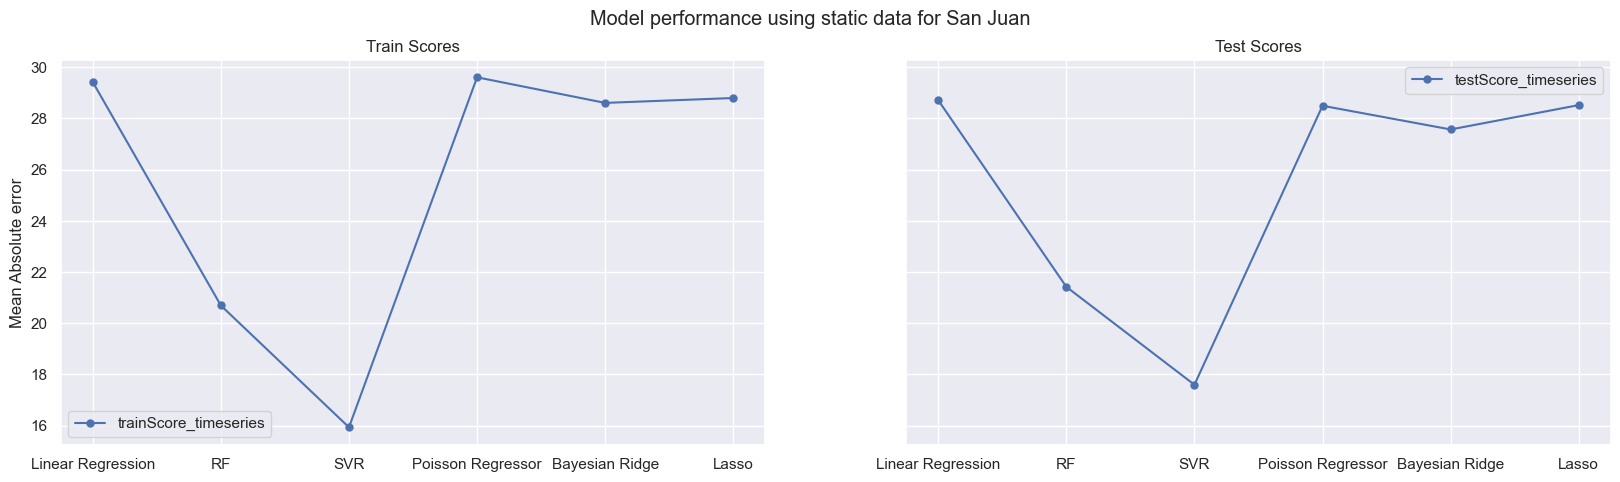

In [49]:
print('San Juan:')
print('Time series Data:')
df = pipeline_cross_val(df_sj_time_series.drop('no_of_cases(t)', axis=1),
                   df_sj_time_series,['trainScore_timeseries','testScore_timeseries'],'no_of_cases(t)')

display(df)

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)

df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Prediction for Iquitos using time series data

Iquitos:
Time series Data:


,trainScore_timeseries,testScore_timeseries
Linear Regression,4.286421,7.300250
RF,2.995167,7.603631
SVR,2.765879,7.489981
Poisson Regressor,3.779274,7.328574
Bayesian Ridge,3.562614,7.330597
Lasso,3.939732,7.441031


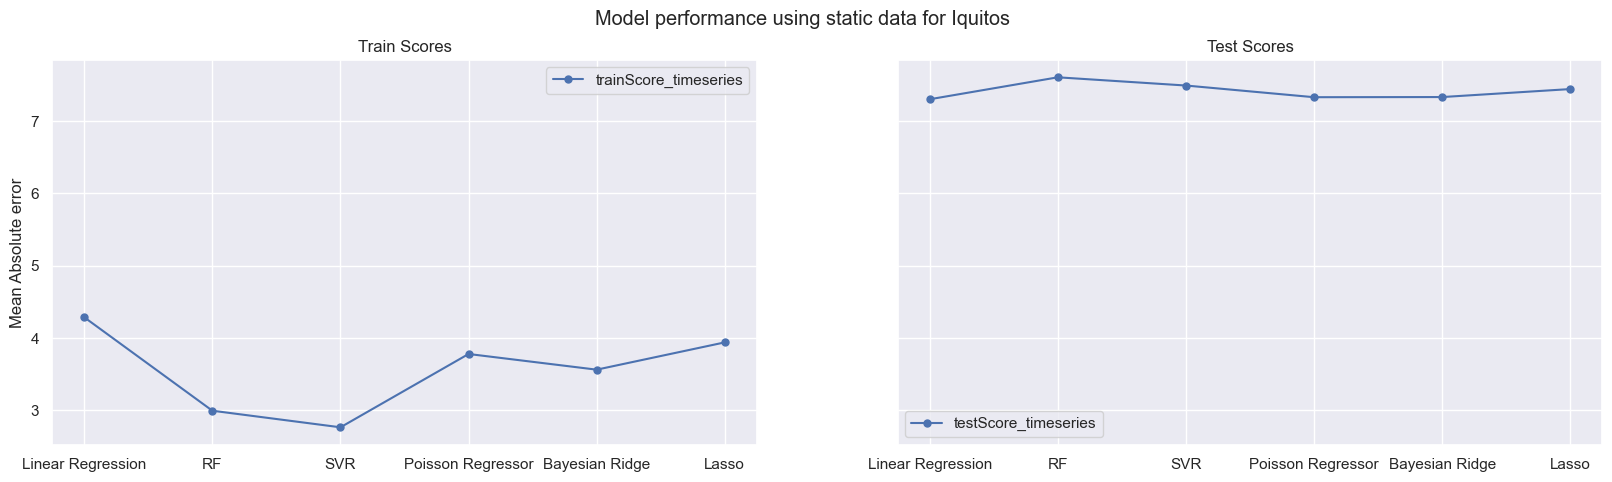

In [50]:
print('Iquitos:')
print('Time series Data:')
df = pipeline_cross_val(df_iq_time_series.drop('no_of_cases(t)', axis=1),
                   df_iq_time_series,['trainScore_timeseries','testScore_timeseries'],'no_of_cases(t)')

display(df)

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)

df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for Iquitos');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Choosing Max Depth Parameter for Random Forest Regressor

In [51]:
# San Juan
print('San Juan')
X_train, X_test, y_train, y_test = hold_out_set(df_sj_time_series.drop('no_of_cases(t)', axis=1),
                                                df_sj_time_series,'no_of_cases(t)',
                                                0.70)

split = TimeSeriesSplit(n_splits=5)
max_depth = [1,2,3,4,5,6,7]
best_score = -999999
for md in max_depth:
    rf_sj = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=md,max_features='auto')
    
    score= cross_val_score(rf_sj, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf_sj.fit(X_train, y_train)
    if score[-1] > best_score:
        best_score = score[-1]
        optimal_parameter_sj = md
        optimal_model_sj = rf_sj

    print('Max depth: ',md)
    print('Scores: ',score)
    print('Training scores: ', score[-1])
    

San Juan
Max depth:  1
Scores:  [-14.59559633 -55.73486239 -32.5743578  -18.43279817 -15.38981651]
Training scores:  -15.389816513761465
Max depth:  2
Scores:  [-20.06724771 -54.83426606 -36.26       -17.8587156  -17.24114679]
Training scores:  -17.241146788990825
Max depth:  3
Scores:  [-22.91087156 -54.54706422 -38.96830275 -19.2540367  -19.96674312]
Training scores:  -19.966743119266056
Max depth:  4
Scores:  [-24.00642202 -55.02334862 -42.72527523 -20.09018349 -21.00853211]
Training scores:  -21.008532110091743
Max depth:  5
Scores:  [-25.13357798 -55.24197248 -44.07477064 -21.37165138 -22.46779817]
Training scores:  -22.467798165137612
Max depth:  6
Scores:  [-25.67844037 -55.19165138 -46.86422018 -22.02472477 -26.35206422]
Training scores:  -26.352064220183482
Max depth:  7
Scores:  [-26.1559633  -55.66733945 -47.58958716 -22.28100917 -25.66688073]
Training scores:  -25.666880733944954


In [52]:
y_pred = optimal_model_sj.predict(X_test)
print('MAE on hold out set for San Juan: ', mae(y_test, y_pred))
print('Optimal depth',optimal_parameter_sj)

MAE on hold out set for San Juan:  16.993014184397158
Optimal depth 1


In [53]:
# Iquitos
print('Iquitos')
X_train, X_test, y_train, y_test = hold_out_set(df_iq_time_series.drop('no_of_cases(t)', axis=1),
                                                df_iq_time_series,'no_of_cases(t)',
                                                0.70)

split = TimeSeriesSplit(n_splits=5)
max_depth = [1,2,3,4,5,6,7]
best_score = -999999
for md in max_depth:
    rf_iq = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=md,max_features='auto')
    
    score= cross_val_score(rf_iq, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf_iq.fit(X_train, y_train)
    if score[-1] > best_score:
        best_score = score[-1]
        optimal_parameter_iq = md
        optimal_model_iq = rf_iq

    print('Max depth: ',md)
    print('Scores: ',score)
    print('Training scores: ', score[-1])
    

Iquitos
Max depth:  1
Scores:  [-9.55683333 -5.05416667 -9.10516667 -5.77441667 -2.78741667]
Training scores:  -2.7874166666666667
Max depth:  2
Scores:  [-9.5025     -6.67383333 -8.87641667 -5.31591667 -2.93416667]
Training scores:  -2.934166666666667
Max depth:  3
Scores:  [-9.48116667 -7.42125    -8.99841667 -5.1355     -3.05383333]
Training scores:  -3.0538333333333325
Max depth:  4
Scores:  [-9.47733333 -8.11925    -8.93866667 -5.28441667 -2.83975   ]
Training scores:  -2.83975
Max depth:  5
Scores:  [-9.47416667 -8.50316667 -8.75       -5.517      -3.13208333]
Training scores:  -3.132083333333333
Max depth:  6
Scores:  [-9.46491667 -8.64758333 -9.05591667 -5.80991667 -3.17758333]
Training scores:  -3.177583333333333
Max depth:  7
Scores:  [-9.47783333 -8.95966667 -9.06633333 -5.69591667 -3.39166667]
Training scores:  -3.3916666666666666


In [54]:
y_pred = optimal_model_iq.predict(X_test)
print('MAE on hold out set for Iquitos: ', mae(y_test, y_pred))
print('Optimal depth',optimal_parameter_iq)

MAE on hold out set for Iquitos:  7.389777070063694
Optimal depth 1


### Predicting unseen test data for the competition

In [55]:
display(df_test_features_sj.head())
display(df_test_features_iq.head())

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,4
1,1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,5
2,2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,5
3,3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5
4,4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,5


,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,...,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2,7
1,261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,...,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9,7
2,262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,...,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6,7
3,263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,...,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8,7
4,264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,...,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0,7


In [56]:
df_train_features_sj.tail()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
931,931,sj,2008,13,2008-03-25,0.07785,-0.039900,0.310471,0.296243,27.19,...,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,3
932,932,sj,2008,14,2008-04-01,-0.03800,-0.016833,0.119371,0.066386,3.82,...,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,4
933,933,sj,2008,15,2008-04-08,-0.15520,-0.052750,0.137757,0.141214,16.96,...,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,4
934,934,sj,2008,16,2008-04-15,0.00180,NaN,0.203900,0.209843,0.00,...,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,4
935,935,sj,2008,17,2008-04-22,-0.03700,-0.010367,0.077314,0.090586,0.00,...,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,4


In [57]:
## Adding training data's last row to the first row of test data
if df_test_features_sj.shape[0] == 260:
    df_test_features_sj.loc[-1] = df_train_features_sj.iloc[-1,:]  
df_test_features_sj.index = df_test_features_sj.index + 1  # shifting index
df_test_features_sj.sort_index(inplace=True) 

df_test_features_sj.head()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,935,sj,2008,17,2008-04-22,-0.0370,-0.010367,0.077314,0.090586,0.00,...,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,4
1,0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,4
2,1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,5
3,2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,5
4,3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5


In [58]:
## Adding training data's last row to the first row of test data
if df_test_features_iq.shape[0] == 156:
    df_test_features_iq.loc[-1] = df_train_features_iq.iloc[-1,:]  
df_test_features_iq.index = df_test_features_iq.index + 1  # shifting index
df_test_features_iq.sort_index(inplace=True) 

df_test_features_iq.head()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,...,89.082857,63.22,17.355714,11.014286,27.475,9.900,33.7,22.2,20.4,6
1,260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,...,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2,7
2,261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,...,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9,7
3,262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,...,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6,7
4,263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,...,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8,7


In [59]:
percent_missing_sj = 100*df_test_features_sj.isnull().sum()/len(df_test_features_sj)
percent_missing_iq = 100*df_test_features_iq.isnull().sum()/len(df_test_features_iq)
df_missing_stats = pd.DataFrame({'precent_missing_sj' : percent_missing_sj, 
                                 'precent_missing_iq' : percent_missing_iq})
df_missing_stats.transpose()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
precent_missing_sj,0.0,0.0,0.0,0.0,0.0,16.475096,4.214559,0.383142,0.383142,0.766284,...,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.0
precent_missing_iq,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.369427,6.369427,0.636943,4.458599,1.910828,0.0


In [60]:
df_test_features_sj_imputed = impute(df_test_features_sj.copy(),'precent_missing_sj',False)
df_test_features_iq_imputed = impute(df_test_features_iq.copy(),'precent_missing_iq',False)
df_test_features_imputed = pd.concat([df_test_features_sj_imputed,df_test_features_iq_imputed])

In [61]:
df_sj_time_series_test = df_test_features_sj_imputed.loc[:,top_10_features_sj_static]
lagged_cols, lagged_col_names = list(), list()
for i in range(1, 0, -1):
    lagged_cols.append(df_sj_time_series_test.shift(i))
    lagged_col_names += [('%s(t-%d)' % (j, i)) for j in top_10_features_sj_static]

for i in range(0, 1):
    lagged_cols.append(df_sj_time_series_test.shift(-i))
    lagged_col_names += [('%s(t)' % j) for j in top_10_features_sj_static]

df_sj_time_series_test = pd.concat(lagged_cols, axis=1)
df_sj_time_series_test.columns = lagged_col_names
df_sj_time_series_test.dropna(inplace=True)
df_sj_time_series_test.head()

,ndvi_sw(t-1),reanalysis_dew_point_temp_k(t-1),reanalysis_precip_amt_kg_per_m2(t-1),reanalysis_tdtr_k(t-1),station_precip_mm(t-1),ndvi_se(t-1),ndvi_nw(t-1),ndvi_ne(t-1),reanalysis_specific_humidity_g_per_kg(t-1),month(t-1),ndvi_sw(t),reanalysis_dew_point_temp_k(t),reanalysis_precip_amt_kg_per_m2(t),reanalysis_tdtr_k(t),station_precip_mm(t),ndvi_se(t),ndvi_nw(t),ndvi_ne(t),reanalysis_specific_humidity_g_per_kg(t),month(t)
1,0.090586,294.280000,2.17,3.957143,0.3,0.077314,-0.010367,-0.037000,15.671429,4.0,0.091200,294.527143,25.37,3.128571,75.2,0.102729,-0.018900,-0.018900,15.918571,4
2,0.091200,294.527143,25.37,3.128571,75.2,0.102729,-0.018900,-0.018900,15.918571,4.0,0.072314,294.395714,21.83,2.571429,34.3,0.082043,-0.012400,-0.018000,15.791429,5
3,0.072314,294.395714,21.83,2.571429,34.3,0.082043,-0.012400,-0.018000,15.791429,5.0,0.091529,295.308571,4.12,4.428571,3.0,0.151083,0.013400,-0.001500,16.674286,5
4,0.091529,295.308571,4.12,4.428571,3.0,0.151083,0.013400,-0.001500,16.674286,5.0,0.125686,294.402857,2.20,4.342857,0.3,0.124329,-0.019867,0.008787,15.775714,5
5,0.125686,294.402857,2.20,4.342857,0.3,0.124329,-0.019867,0.008787,15.775714,5.0,0.075914,294.760000,4.36,3.542857,84.1,0.062267,0.039833,0.056800,16.137143,5


In [62]:
df_iq_time_series_test = df_test_features_iq_imputed.loc[:,top_10_features_iq_static]
lagged_cols, lagged_col_names = list(), list()
for i in range(1, 0, -1):
    lagged_cols.append(df_iq_time_series_test.shift(i))
    lagged_col_names += [('%s(t-%d)' % (j, i)) for j in top_10_features_iq_static]

for i in range(0, 1):
    lagged_cols.append(df_iq_time_series_test.shift(-i))
    lagged_col_names += [('%s(t)' % j) for j in top_10_features_iq_static]

df_iq_time_series_test = pd.concat(lagged_cols, axis=1)
df_iq_time_series_test.columns = lagged_col_names
df_iq_time_series_test.dropna(inplace=True)
df_iq_time_series_test.head()

,ndvi_nw(t-1),reanalysis_min_air_temp_k(t-1),reanalysis_relative_humidity_percent(t-1),station_min_temp_c(t-1),station_avg_temp_c(t-1),reanalysis_specific_humidity_g_per_kg(t-1),reanalysis_precip_amt_kg_per_m2(t-1),station_precip_mm(t-1),station_diur_temp_rng_c(t-1),reanalysis_dew_point_temp_k(t-1),ndvi_nw(t),reanalysis_min_air_temp_k(t),reanalysis_relative_humidity_percent(t),station_min_temp_c(t),station_avg_temp_c(t),reanalysis_specific_humidity_g_per_kg(t),reanalysis_precip_amt_kg_per_m2(t),station_precip_mm(t),station_diur_temp_rng_c(t),reanalysis_dew_point_temp_k(t)
1,0.232971,292.3,89.082857,22.2,27.475,17.355714,36.90,20.4,9.900,295.807143,0.142500,293.7,92.581429,21.5,27.440,17.654286,34.11,11.2,10.760,296.118571
2,0.142500,293.7,92.581429,21.5,27.440,17.654286,34.11,11.2,10.760,296.118571,0.272267,292.2,83.885714,21.2,27.025,16.320000,9.10,8.9,9.625,294.831429
3,0.272267,292.2,83.885714,21.2,27.025,16.320000,9.10,8.9,9.625,294.831429,0.366457,292.5,92.057143,21.6,26.950,18.030000,61.09,22.6,10.350,296.417143
4,0.366457,292.5,92.057143,21.6,26.950,18.030000,61.09,22.6,10.350,296.417143,0.063214,289.3,88.970000,14.2,26.900,15.394286,19.60,4.8,9.700,293.638571
5,0.063214,289.3,88.970000,14.2,26.900,15.394286,19.60,4.8,9.700,293.638571,0.327683,290.5,78.610000,16.9,27.050,15.468571,18.93,3.0,11.850,293.892857


In [63]:
y_pred_test_sj = np.ceil(optimal_model_sj.predict(df_sj_time_series_test))
y_pred_test_iq = np.ceil(optimal_model_iq.predict(df_iq_time_series_test))
y_predictions = np.append(y_pred_test_sj, y_pred_test_iq)
submission['total_cases'] = y_predictions
submission['total_cases'] = pd.to_numeric(submission['total_cases'], downcast='integer')

<AxesSubplot:ylabel='Frequency'>

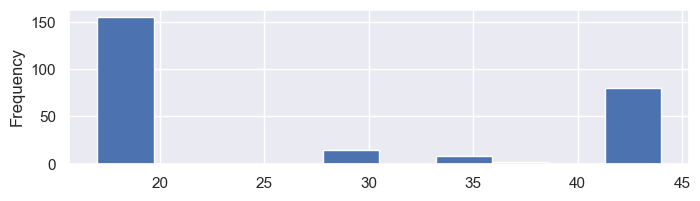

In [64]:
submission.loc[submission['city']=='sj','total_cases'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

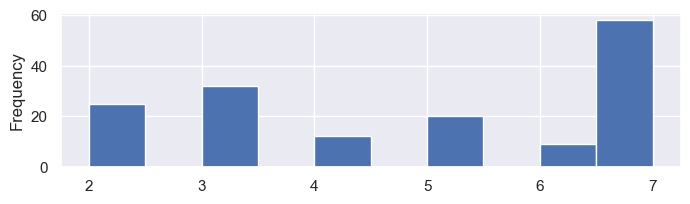

In [65]:
submission.loc[submission['city']=='iq','total_cases'].plot(kind='hist')

In [66]:
submission.to_csv('data/submission1.csv', index=False)

### Submission 2

In [67]:
svc_sj = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5))
X_train, X_test, y_train, y_test = hold_out_set(df_sj_time_series.drop('no_of_cases(t)', axis=1),df_sj_time_series,'no_of_cases(t)',0.70)
model_sj = svc_sj.fit(X_train,y_train)

y_pred_test_sj = np.ceil(model_sj.predict(df_sj_time_series_test))

svc_iq = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5))
X_train, X_test, y_train, y_test = hold_out_set(df_iq_time_series.drop('no_of_cases(t)', axis=1),df_iq_time_series,'no_of_cases(t)',0.70)
model_iq = svc_iq.fit(X_train,y_train)

y_pred_test_iq = np.ceil(model_iq.predict(df_iq_time_series_test))

y_predictions = np.append(y_pred_test_sj, y_pred_test_iq)
submission['total_cases'] = y_predictions
submission['total_cases'] = pd.to_numeric(submission['total_cases'], downcast='integer')

In [68]:
submission.to_csv('data/submission2.csv', index=False)

### Submission 3

In [69]:
rf_sj = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=4)
X_train, X_test, y_train, y_test = hold_out_set(df_sj_time_series.drop('no_of_cases(t)', axis=1),df_sj_time_series,'no_of_cases(t)',0.70)
model_sj = rf_sj.fit(X_train,y_train)

y_pred_test_sj = np.ceil(model_sj.predict(df_sj_time_series_test))

rf_iq = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=4)
X_train, X_test, y_train, y_test = hold_out_set(df_iq_time_series.drop('no_of_cases(t)', axis=1),df_iq_time_series,'no_of_cases(t)',0.70)
model_iq = rf_iq.fit(X_train,y_train)

y_pred_test_iq = np.ceil(model_iq.predict(df_iq_time_series_test))

y_predictions = np.append(y_pred_test_sj, y_pred_test_iq)
submission['total_cases'] = y_predictions
submission['total_cases'] = pd.to_numeric(submission['total_cases'], downcast='integer')

In [70]:
submission.to_csv('data/submission3.csv', index=False)